In [98]:
# Handle Warnings
import warnings
warnings.filterwarnings('ignore')

# Data Handling
import numpy as np
import pandas as pd
from scipy.stats.mstats import winsorize


# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly as ply

# Stats
import statsmodels.api as sm
from scipy import stats
import pylab
from math import log10, sqrt

# sklearn and imblearn
from imblearn.over_sampling import SMOTE
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split, cross_val_score
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from lazypredict.Supervised import LazyRegressor
import lazypredict


# Deep Learning
import tensorflow as tf
from scikeras.wrappers import KerasClassifier
from keras_tuner import RandomSearch
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU
from tensorflow.keras.models import Sequential




# Methods

In [220]:
def check_balance(df, col):
    '''
    Plots over the target column with
    a countplot to check for imbalances
    '''
    ax = sns.countplot(x=col, data=df, palette='pastel')

    total = df[col].notnull().sum()  # Adjust total

    # Annotate the bars
    for p in ax.patches:
        percentage = f'{100 * p.get_height() / total:.1f}% of total'  # Calculate percentage based on patch height
        x = p.get_x() + p.get_width() / 2  # Middle of the bar
        y = p.get_height()  # Height of the bar
        ax.annotate(percentage, (x, y), ha='center', va='bottom')  # Adjust text alignment|

    # Set labels and title
    ax.set_xlabel(col)
    ax.set_ylabel('Count')
    ax.set_title(f'{col} Distribution')

    plt.show()

In [226]:
def feature_plotter(df,colname):
    '''
    Takes a df and a target feature and 
    plots relevant distribution information
    '''
    col = df[colname]
    fig, ax = plt.subplots(1, 2, figsize = (10,4))

    ax[0].hist(col, bins=100)
    ax[0].set_ylabel(colname)
    ax[1].set_xlabel(colname)


    ax[0].axvline(col.mean(), color = 'magenta', linestyle='--', linewidth=2)
    ax[0].axvline(col.median(), color = 'cyan', linestyle='--', linewidth=2, )
    ax[0].set_xlabel(colname)
    ax[0].set_ylabel('count')

    ax[1].boxplot(col.dropna(), vert=False)
    ax[1].set_xlabel(colname)

    fig.suptitle(f'{colname} Distribution -- NA dropped: {col.isnull().sum()}')

    fig.show()

In [101]:
from sklearn.impute import KNNImputer

outliern = 2

def outlier_n_iqr_clean_winsorize(df,colname,outliern=outliern,n_neighbors=2)->pd.core.series.Series:
    '''
    Casts any values that fall outside of the specified 
    outlier range: (outliern * IQR upper bound) as null values
    Imputes any existing null values with KNNImputer
    Winsorizes data based on standard IQR ranges
    '''
    def IQR_max(s):
        q1 = s.quantile(.25)
        q3 = s.quantile(.75)
        return q3 + 1.5*(q3-q1)
    def IQR_min(s):
        q1 = s.quantile(.25)
        q3 = s.quantile(.75)
        return q1 - 1.5*(q3-q1)
    iqr_max = IQR_max(df[colname])
    print('Cleaning column: ',colname,'-- Outliers: ',df[colname][df[colname] > iqr_max * outliern].unique())
    df[colname] = df[colname].apply(lambda x: x if x < iqr_max * outliern else np.NaN)
    if df[colname].isnull().sum() > 0:
        print('Imputing: nullcount: ',df[colname].isnull().sum())
        df_copy = df.copy(deep=True)
        imputer = KNNImputer(n_neighbors=n_neighbors)
        impute_result = imputer.fit_transform(df[colname].reset_index())
        df[colname] = [i[1] for i in impute_result]
    iqr_max = IQR_max(df[colname])
    iqr_min = IQR_min(df[colname])
    print(f'IQR: {iqr_min}:{iqr_max}')
    df[colname] = df[colname].apply(lambda x:iqr_min if x<iqr_min else x if x<iqr_max else iqr_max)
    print('Winsorizing column done: ',colname,'-- Outliers: ',df[colname][df[colname] > iqr_max * outliern].unique())
    return df[colname]

    
def naimpute(df,colname):
    k = KNNImputer()
    df[colname] = k.fit_transform(df[[colname]])
    
from math import log10,sqrt

def logscale(df,colname,base = 10):
    def loghelper(x,base = 10):
        if type(x) not in [float,int]: raise ValueError('wrong datatype')
        x = float(x)
        if x == 0: return 0
        if x < 0: raise AttributeError('negative value entered')
        return log10(x)/log10(base)
    return df[colname].apply(lambda x: loghelper(x,base))

def sqrtscale(df,colname):
    def sqrthelper(x):
        if type(x) not in [float,int]: raise ValueError('wrong datatype')
        x = float(x)
        if x == 0: return 0
        if x < 0: raise AttributeError('negative value entered')
        return sqrt(x)
    return df[colname].apply(lambda x: sqrthelper(x))


# Filter functions to plot based on certain date filters

In [208]:
def datefilter(df, start_date: str, end_date: str):
    df = df.copy(deep=True)
    
    # Filter data wrt range
    mask = (df['date'] >= pd.to_datetime(start_date, format='%d/%m/%Y')) & (df['date'] <= pd.to_datetime(end_date, format='%d/%m/%Y'))
    filtered_df = df.loc[mask]

    return filtered_df

In [287]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_date_range_data(df, start_date: str, end_date: str):
    """
    Plots histograms and a pairplot for numeric columns within a specified date range using Matplotlib and Seaborn.
    
    Input:
    df
    start_date (str): Start date in 'dd/mm/yyyy' format.
    end_date (str): End date in 'dd/mm/yyyy' format.
    """
    
    # type check
    df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y %H:%M')
    
    # Filter data wrt range
    mask = (df['date'] >= pd.to_datetime(start_date, format='%d/%m/%Y')) & (df['date'] <= pd.to_datetime(end_date, format='%d/%m/%Y'))
    filtered_df = df.loc[mask]
    
    # Handle numeric cols
    numeric_cols = filtered_df.select_dtypes(include=['number']).columns.tolist()
    if not numeric_cols:
        print("No numeric columns to display.")
        return
    
    # Format subplots w/ 3 cols
    n_cols = 3
    n_rows = (len(numeric_cols) + n_cols - 1) // n_cols

    # Histograms
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 9))
    axes = axes.flatten()

    for i, col in enumerate(numeric_cols):
        sns.histplot(filtered_df[col], kde=False, ax=axes[i])
        axes[i].set_title(f'Histogram of {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Frequency')

    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

    # Create a pairplot if applicable
    if len(numeric_cols) > 1:
        sns.pairplot(filtered_df[numeric_cols])
        plt.suptitle('Pairplot of Numeric Features')
        plt.show()
    else:
        print("Not enough numeric columns for a pairplot.")

# Example usage of code to filter based on necessary metrics

In [295]:
import pandas as pd

def date_time_and_load_type_filter(df, start_date=None, end_date=None, day_of_week=None, month=None, year=None, tag=None):
    df = df.copy(deep=True)

    # Convert 'date' column to datetime once at the beginning if any date-related filtering is needed
    if any([start_date, end_date, day_of_week, month, year]):
        df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y %H:%M')

    # Date range filtering
    if start_date and end_date:
        mask = (df['date'] >= pd.to_datetime(start_date, format='%d/%m/%Y')) & \
               (df['date'] <= pd.to_datetime(end_date, format='%d/%m/%Y'))
        df = df.loc[mask]

    # Filter by day of the week
    if day_of_week:
        df = df[df['date'].dt.day_name() == day_of_week]

    # Filter by month and year
    if month and year:
        df = df[(df['date'].dt.month == month) & (df['date'].dt.year == year)]

    # Tag-based filtering
    if tag is not None:
        taglist = ['Light_Load', 'Medium_Load', 'Maximum_Load']
        if tag >= 0 and tag < len(taglist):
            df = df[df['Load_Type'] == taglist[tag]]

    return df

df = pd.read_csv('Steel_industry_data.csv')

# How much average power was consumed on Tuesdays in October 2018:
oct_2018_tues = date_time_and_load_type_filter(df, start_date="01/10/2018", end_date="31/10/2018", day_of_week="Tuesday", tag=2)
average_consumption = oct_2018_tues['Usage_kWh'].mean()
print(f"Average Consumption on Tuesdays in October 2018: {average_consumption} kWh")

# Print statistics for tag filters where 0 = Light, 1 = Medium, 2 = Maximum
def min_max_mean(df, tag=0):
    max_load_data = date_time_and_load_type_filter(df, tag=tag)
    min_consumption = max_load_data['Usage_kWh'].min()
    max_consumption = max_load_data['Usage_kWh'].max()
    mean_consumption = max_load_data['Usage_kWh'].mean()
    print(f"Min Consumption: {min_consumption} kWh, Max Consumption: {max_consumption} kWh, Mean Consumption: {mean_consumption} kWh")

# Example to show usage of min_max_mean function
min_max_mean(df, tag=0)    # Light Load
min_max_mean(df, tag=1)    # Medium Load
min_max_mean(df, tag=2)    # Maximum Load


Average Consumption on Tuesdays in October 2018: 63.356416666666654 kWh
Min Consumption: 0.0 kWh, Max Consumption: 140.29 kWh, Mean Consumption: 8.626206839309429 kWh
Min Consumption: 2.52 kWh, Max Consumption: 157.18 kWh, Mean Consumption: 38.44539397689769 kWh
Min Consumption: 2.92 kWh, Max Consumption: 151.67 kWh, Mean Consumption: 59.26531353135314 kWh


In [266]:
oct_2018_mondays

Empty DataFrame
Columns: [date, Usage_kWh, Lagging_Current_Reactive.Power_kVarh, Leading_Current_Reactive_Power_kVarh, CO2(tCO2), Lagging_Current_Power_Factor, Leading_Current_Power_Factor, NSM, WeekStatus, Day_of_week, Load_Type]
Index: []

In [231]:
x = pd.read_csv('Steel_industry_data.csv')

In [232]:
x.head(4)

date  Usage_kWh  Lagging_Current_Reactive.Power_kVarh  \
0  01/01/2018 00:15       3.17                                  2.95   
1  01/01/2018 00:30       4.00                                  4.46   
2  01/01/2018 00:45       3.24                                  3.28   
3  01/01/2018 01:00       3.31                                  3.56   

   Leading_Current_Reactive_Power_kVarh  CO2(tCO2)  \
0                                  0.00       0.00   
1                                  0.00       0.00   
2                                  0.00       0.00   
3                                  0.00       0.00   

   Lagging_Current_Power_Factor  Leading_Current_Power_Factor   NSM  \
0                         73.21                        100.00   900   
1                         66.77                        100.00  1800   
2                         70.28                        100.00  2700   
3                         68.09                        100.00  3600   

  WeekStatus Day_of_week   Load_Type  
0    Weekday      Monday  Light_Load  
1    Weekday      Monday  Light_Load  
2    Weekday      Monday  Light_Load  
3    Weekday      Monday  Light_Load

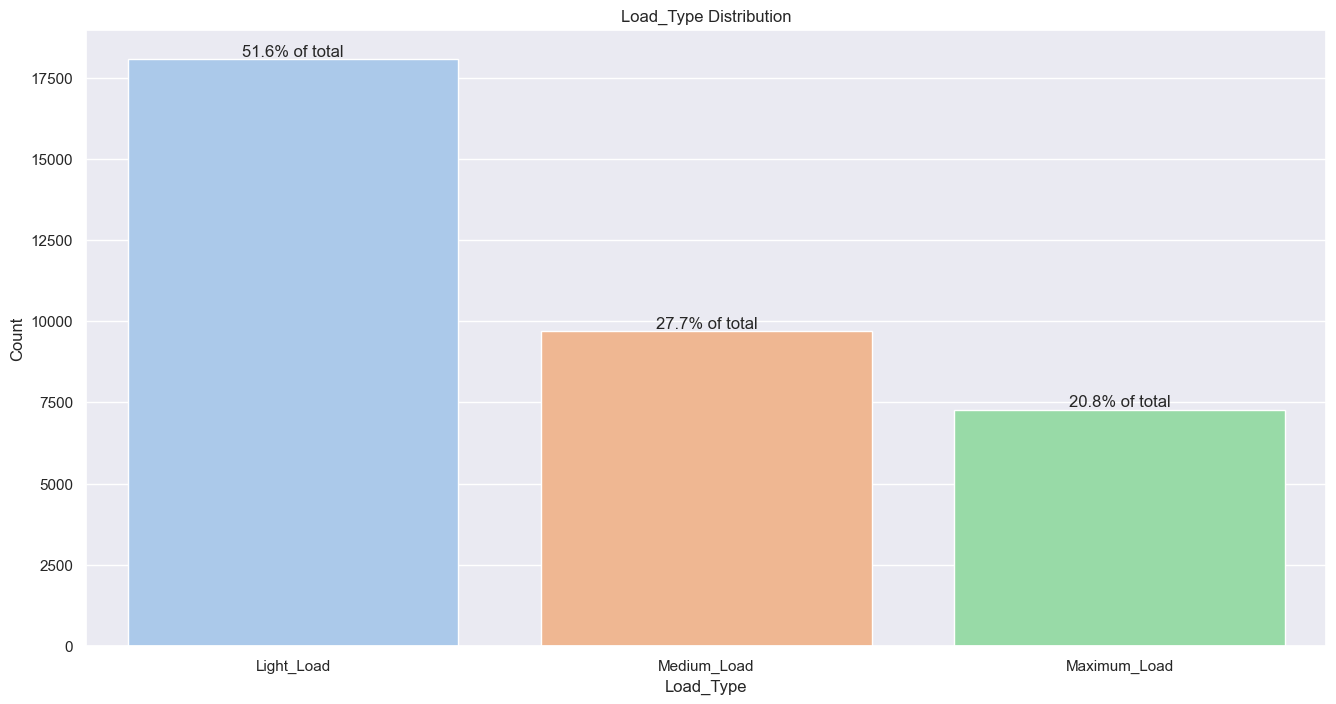

In [233]:
check_balance(x,'Load_Type')

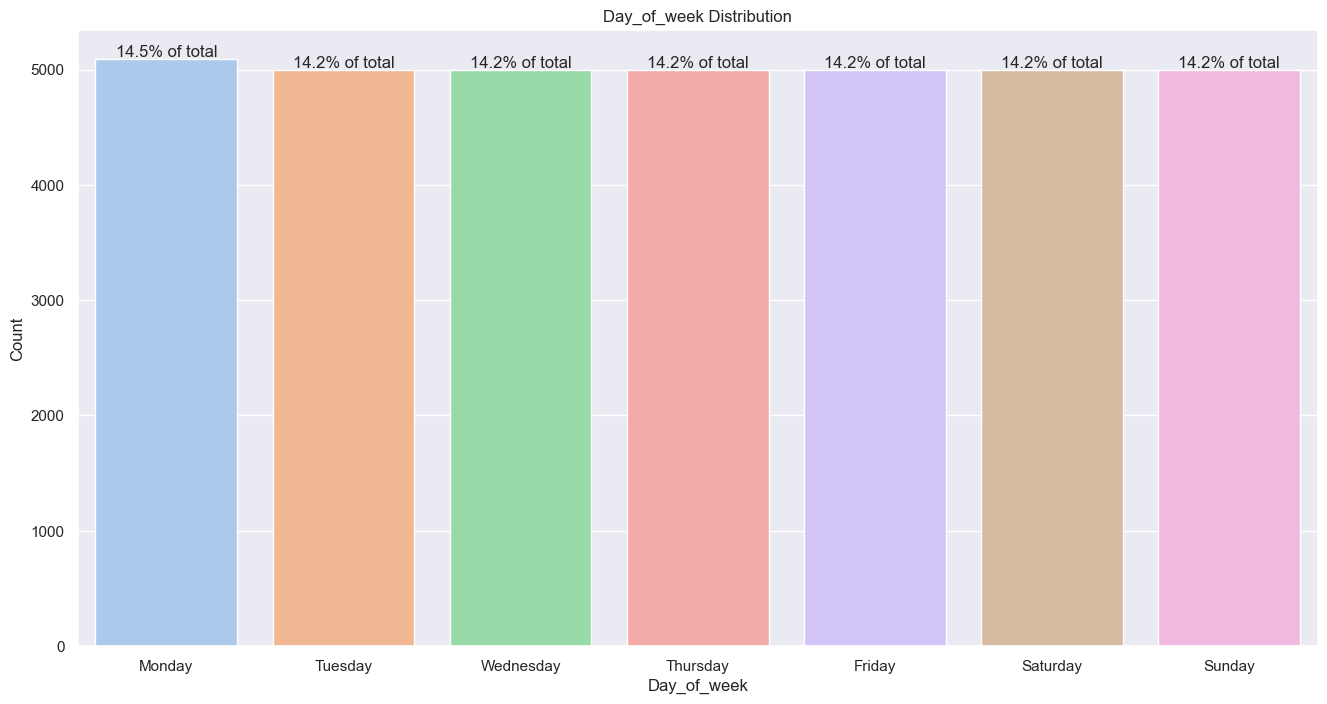

In [234]:
check_balance(x, 'Day_of_week')

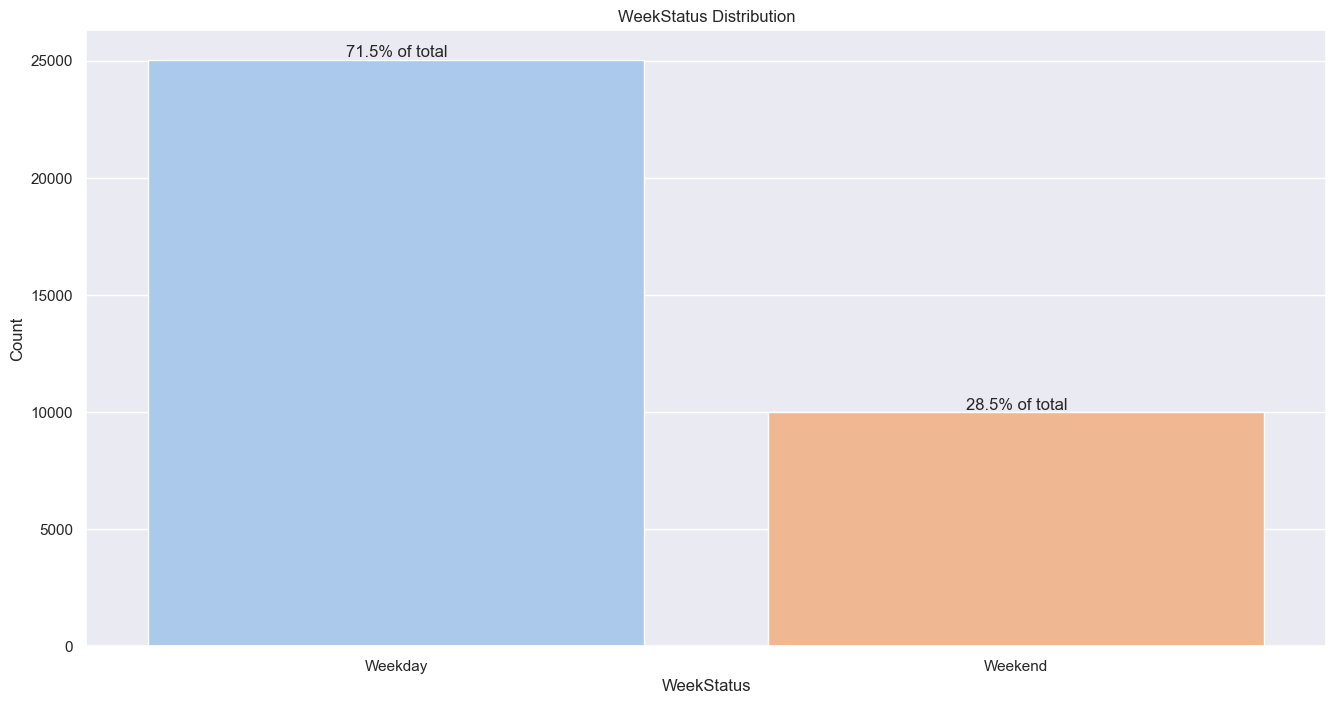

In [235]:
check_balance(x, 'WeekStatus')

In [236]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35040 entries, 0 to 35039
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   date                                  35040 non-null  object 
 1   Usage_kWh                             35040 non-null  float64
 2   Lagging_Current_Reactive.Power_kVarh  35040 non-null  float64
 3   Leading_Current_Reactive_Power_kVarh  35040 non-null  float64
 4   CO2(tCO2)                             35040 non-null  float64
 5   Lagging_Current_Power_Factor          35040 non-null  float64
 6   Leading_Current_Power_Factor          35040 non-null  float64
 7   NSM                                   35040 non-null  int64  
 8   WeekStatus                            35040 non-null  object 
 9   Day_of_week                           35040 non-null  object 
 10  Load_Type                             35040 non-null  object 
dtypes: float64(6), 

In [237]:
x['Load_Type'] = x['Load_Type'].apply(lambda x: 0 if x == 'Light_Load' else '1' if x == 'Medium_Load' else 2)
x['Load_Type'] = pd.to_numeric(x['Load_Type'])

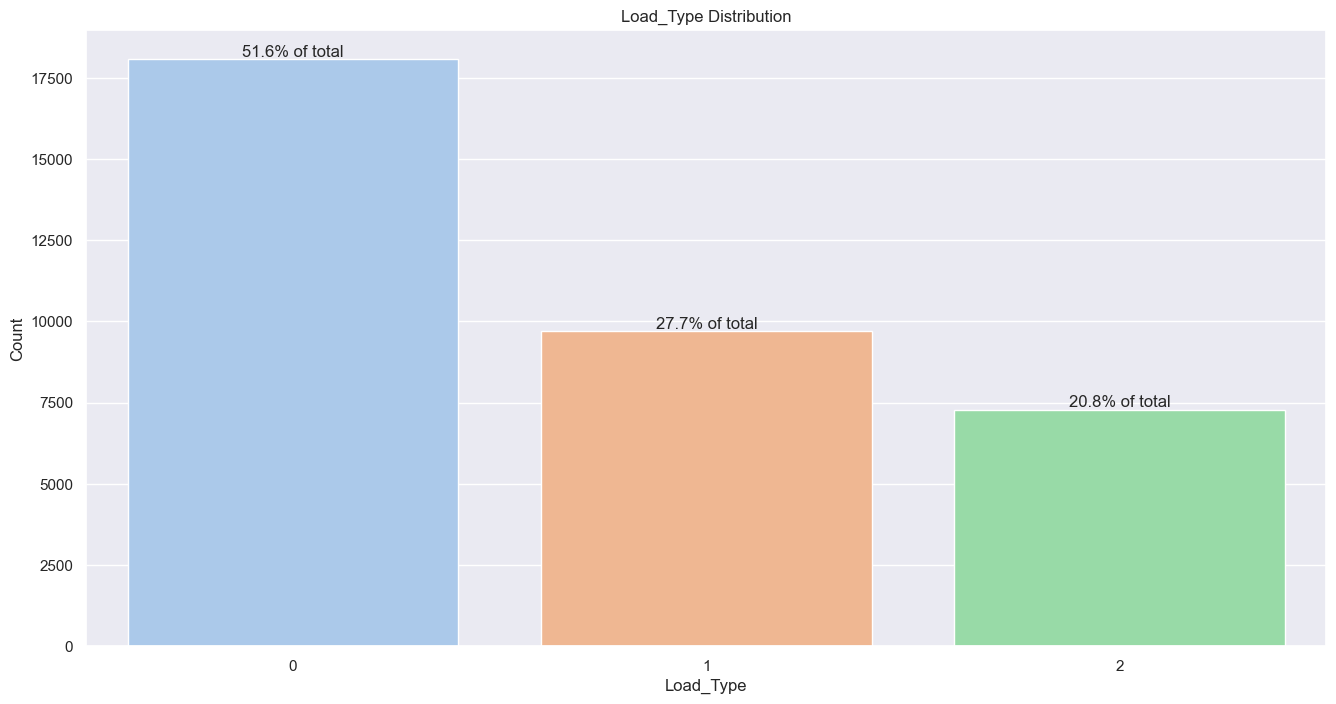

In [238]:
check_balance(x,'Load_Type')

In [239]:
x['date'] = pd.to_datetime(x['date'], format='%d/%m/%Y %H:%M')

In [240]:
x.describe()

date  Usage_kWh  Lagging_Current_Reactive.Power_kVarh  \
count                35040   35040.00                              35040.00   
mean   2018-07-02 11:52:30      27.39                                 13.04   
min    2018-01-01 00:00:00       0.00                                  0.00   
25%    2018-04-02 05:56:15       3.20                                  2.30   
50%    2018-07-02 11:52:30       4.57                                  5.00   
75%    2018-10-01 17:48:45      51.24                                 22.64   
max    2018-12-31 23:45:00     157.18                                 96.91   
std                    NaN      33.44                                 16.31   

       Leading_Current_Reactive_Power_kVarh  CO2(tCO2)  \
count                              35040.00   35040.00   
mean                                   3.87       0.01   
min                                    0.00       0.00   
25%                                    0.00       0.00   
50%                                    0.00       0.00   
75%                                    2.09       0.02   
max                                   27.76       0.07   
std                                    7.42       0.02   

       Lagging_Current_Power_Factor  Leading_Current_Power_Factor      NSM  \
count                      35040.00                      35040.00 35040.00   
mean                          80.58                         84.37 42750.00   
min                            0.00                          0.00     0.00   
25%                           63.32                         99.70 21375.00   
50%                           87.96                        100.00 42750.00   
75%                           99.02                        100.00 64125.00   
max                          100.00                        100.00 85500.00   
std                           18.92                         30.46 24940.53   

       Load_Type  
count   35040.00  
mean        0.69  
min         0.00  
25%         0.00  
50%         0.00  
75%         1.00  
max         2.00  
std         0.79

In [241]:
# Check nulls
x.isnull().sum()[x.isnull().sum()>0]

Series([], dtype: int64)

In [242]:
# Dictionary to map days to numbers
day_to_number = {
    'Monday': 1,
    'Tuesday': 2,
    'Wednesday': 3,
    'Thursday': 4,
    'Friday': 5,
    'Saturday': 6,
    'Sunday': 7
}

x.Day_of_week = x.Day_of_week.apply(lambda x: day_to_number[x])

In [243]:
# Dictionary to map weekday vs weekend
weekday_encoded = {
    'Weekday': 0,
    'Weekend': 1
}

x.WeekStatus = x.WeekStatus.apply(lambda x: weekday_encoded[x])

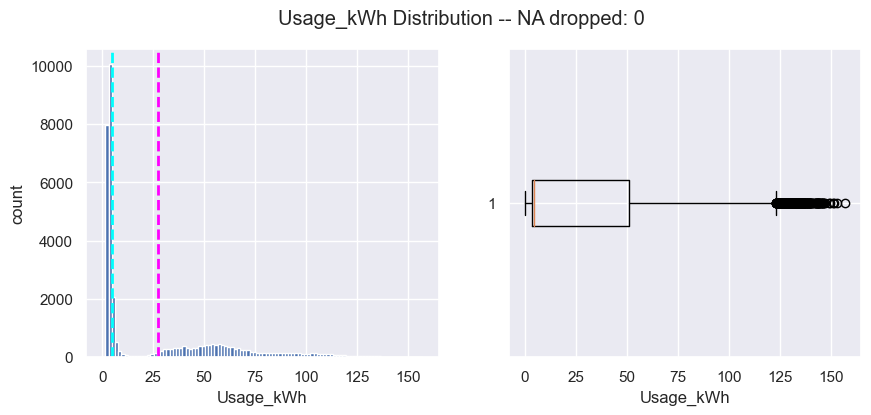

In [244]:
feature_plotter(x, 'Usage_kWh')

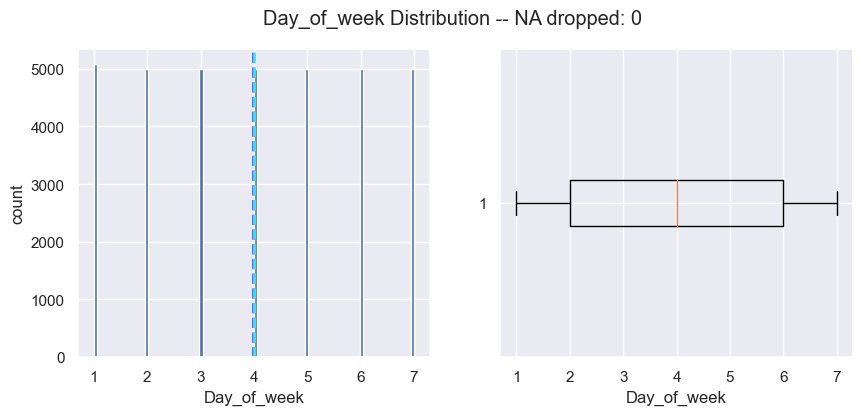

In [246]:
feature_plotter(x, 'Day_of_week')

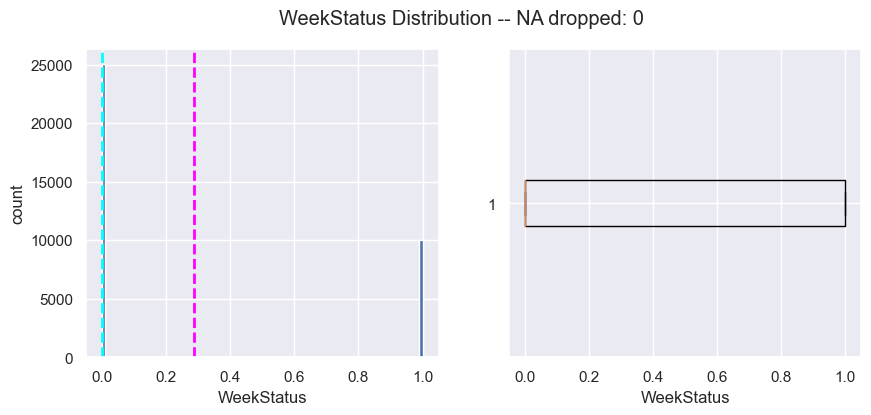

In [247]:
feature_plotter(x, 'WeekStatus')

In [248]:
x.head()

date  Usage_kWh  Lagging_Current_Reactive.Power_kVarh  \
0 2018-01-01 00:15:00       3.17                                  2.95   
1 2018-01-01 00:30:00       4.00                                  4.46   
2 2018-01-01 00:45:00       3.24                                  3.28   
3 2018-01-01 01:00:00       3.31                                  3.56   
4 2018-01-01 01:15:00       3.82                                  4.50   

   Leading_Current_Reactive_Power_kVarh  CO2(tCO2)  \
0                                  0.00       0.00   
1                                  0.00       0.00   
2                                  0.00       0.00   
3                                  0.00       0.00   
4                                  0.00       0.00   

   Lagging_Current_Power_Factor  Leading_Current_Power_Factor   NSM  \
0                         73.21                        100.00   900   
1                         66.77                        100.00  1800   
2                         70.28                        100.00  2700   
3                         68.09                        100.00  3600   
4                         64.72                        100.00  4500   

   WeekStatus  Day_of_week  Load_Type  
0           0            1          0  
1           0            1          0  
2           0            1          0  
3           0            1          0  
4           0            1          0

In [249]:
# Subplots length for numerical columns
numeric_columns = x.select_dtypes(include=['number']).columns
print(f"Number of numeric columns: {len(numeric_columns)}")

Number of numeric columns: 10


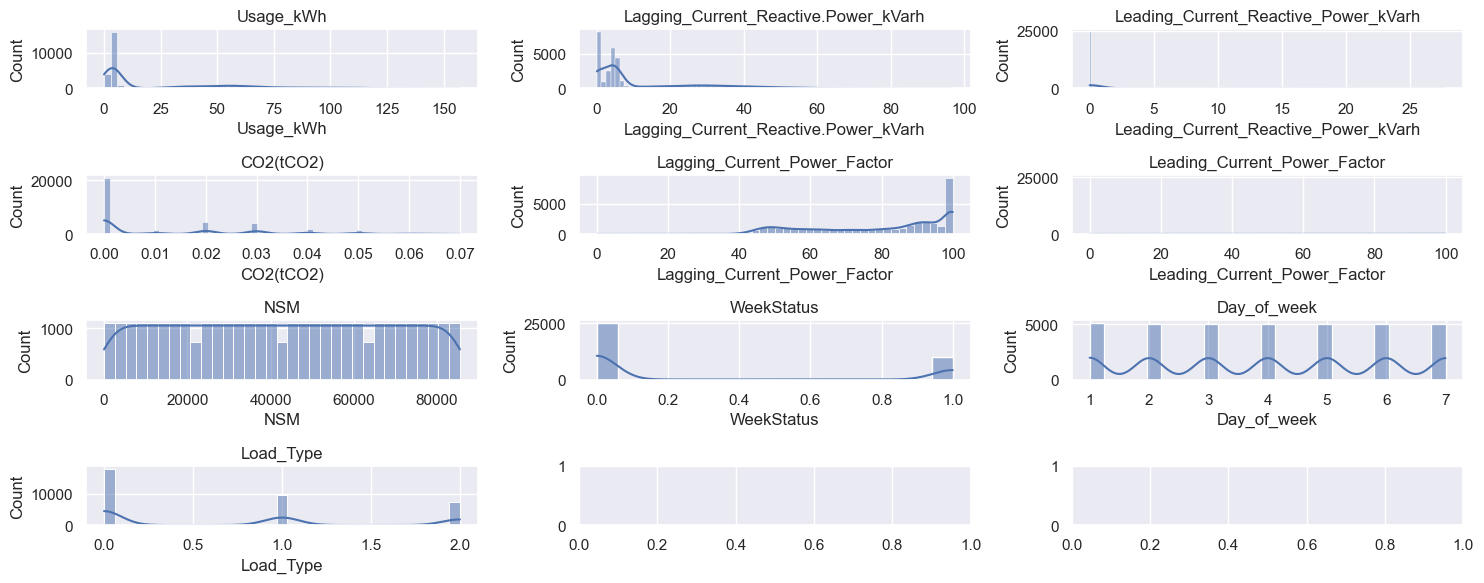

In [120]:
# Hists before transformations
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 6))
axes = axes.flatten()
for i, ax in enumerate(axes):
    if i < len(numeric_columns):
        sns.histplot(x[numeric_columns[i]], ax=ax, kde=True)
        ax.set_title(numeric_columns[i])
plt.tight_layout()
plt.show()

In [250]:
x.columns

Index(['date', 'Usage_kWh', 'Lagging_Current_Reactive.Power_kVarh',
       'Leading_Current_Reactive_Power_kVarh', 'CO2(tCO2)',
       'Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor', 'NSM',
       'WeekStatus', 'Day_of_week', 'Load_Type'],
      dtype='object')

In [252]:
logscale_cols = ['Usage_kWh', 'Lagging_Current_Reactive.Power_kVarh', 'Leading_Current_Reactive_Power_kVarh', 'CO2(tCO2)']
sqrt_cols = []

In [253]:
# Assuming 'x' is your DataFrame and logscale_cols is defined
for col in numeric_columns:
    if col in logscale_cols:
        # Apply log scaling first
        x[col] = logscale(x, col)
        # Handle non-positive values gracefully
        x[col].fillna(x[col].min(), inplace=True)  # You can adjust this handling method as needed

    # Then clean outliers
    outlier_n_iqr_clean_winsorize(x, col, n_neighbors=3)  # Modify n_neighbors as needed

print(x.head())

Cleaning column:  Usage_kWh -- Outliers:  []
IQR: -1.301506930254203:3.516244825943421
Winsorizing column done:  Usage_kWh -- Outliers:  []
Cleaning column:  Lagging_Current_Reactive.Power_kVarh -- Outliers:  []
IQR: -1.1279950437303685:2.844599302264195
Winsorizing column done:  Lagging_Current_Reactive.Power_kVarh -- Outliers:  []
Cleaning column:  Leading_Current_Reactive_Power_kVarh -- Outliers:  []
IQR: -0.4802194291665809:0.8003657152776349
Winsorizing column done:  Leading_Current_Reactive_Power_kVarh -- Outliers:  []
Cleaning column:  CO2(tCO2) -- Outliers:  []
IQR: -3.8071968632008444:2.2843181179205065
Winsorizing column done:  CO2(tCO2) -- Outliers:  []
Cleaning column:  Lagging_Current_Power_Factor -- Outliers:  []
IQR: 9.766250000000007:152.57625
Winsorizing column done:  Lagging_Current_Power_Factor -- Outliers:  []
Cleaning column:  Leading_Current_Power_Factor -- Outliers:  []
IQR: 99.25:100.44999999999999
Winsorizing column done:  Leading_Current_Power_Factor -- Outlie

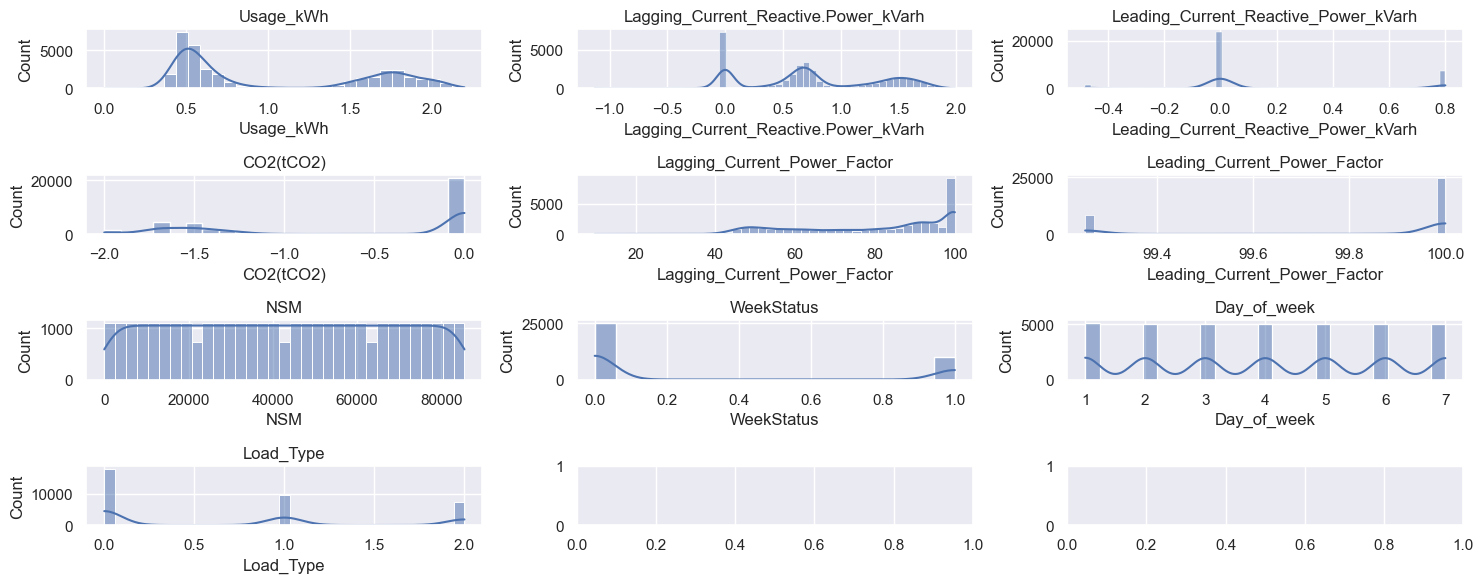

In [124]:
# Hists after transformations
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 6))
axes = axes.flatten()
for i, ax in enumerate(axes):
    if i < len(numeric_columns):
        sns.histplot(x[numeric_columns[i]], ax=ax, kde=True)
        ax.set_title(numeric_columns[i])
plt.tight_layout()
plt.show()

In [254]:
x.columns

Index(['date', 'Usage_kWh', 'Lagging_Current_Reactive.Power_kVarh',
       'Leading_Current_Reactive_Power_kVarh', 'CO2(tCO2)',
       'Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor', 'NSM',
       'WeekStatus', 'Day_of_week', 'Load_Type'],
      dtype='object')

In [255]:
x.head(5)

date  Usage_kWh  Lagging_Current_Reactive.Power_kVarh  \
0 2018-01-01 00:15:00       0.50                                  0.47   
1 2018-01-01 00:30:00       0.60                                  0.65   
2 2018-01-01 00:45:00       0.51                                  0.52   
3 2018-01-01 01:00:00       0.52                                  0.55   
4 2018-01-01 01:15:00       0.58                                  0.65   

   Leading_Current_Reactive_Power_kVarh  CO2(tCO2)  \
0                                  0.00       0.00   
1                                  0.00       0.00   
2                                  0.00       0.00   
3                                  0.00       0.00   
4                                  0.00       0.00   

   Lagging_Current_Power_Factor  Leading_Current_Power_Factor   NSM  \
0                         73.21                        100.00   900   
1                         66.77                        100.00  1800   
2                         70.28                        100.00  2700   
3                         68.09                        100.00  3600   
4                         64.72                        100.00  4500   

   WeekStatus  Day_of_week  Load_Type  
0           0            1          0  
1           0            1          0  
2           0            1          0  
3           0            1          0  
4           0            1          0

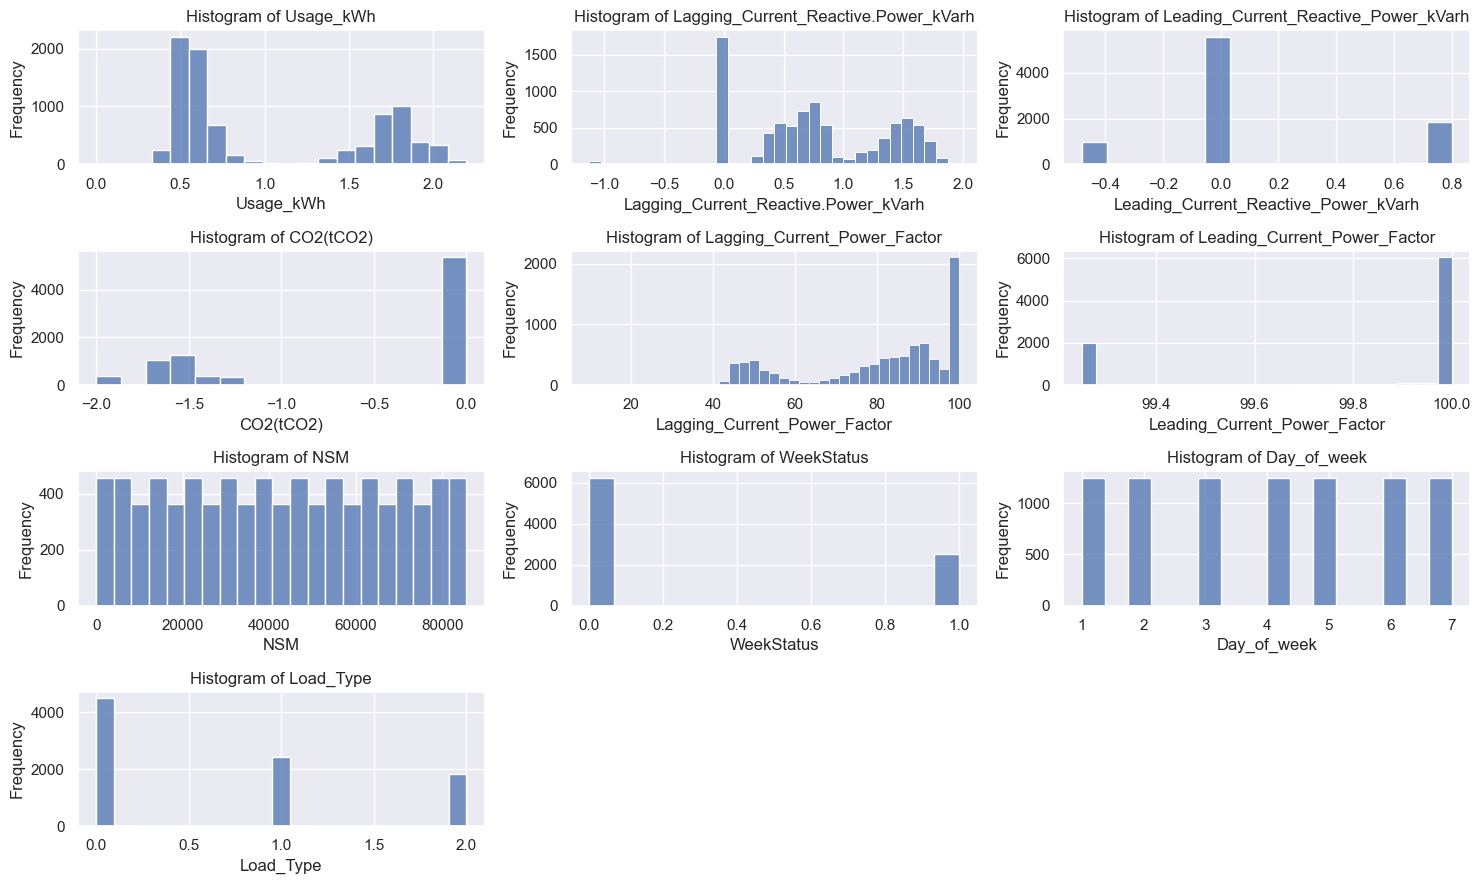

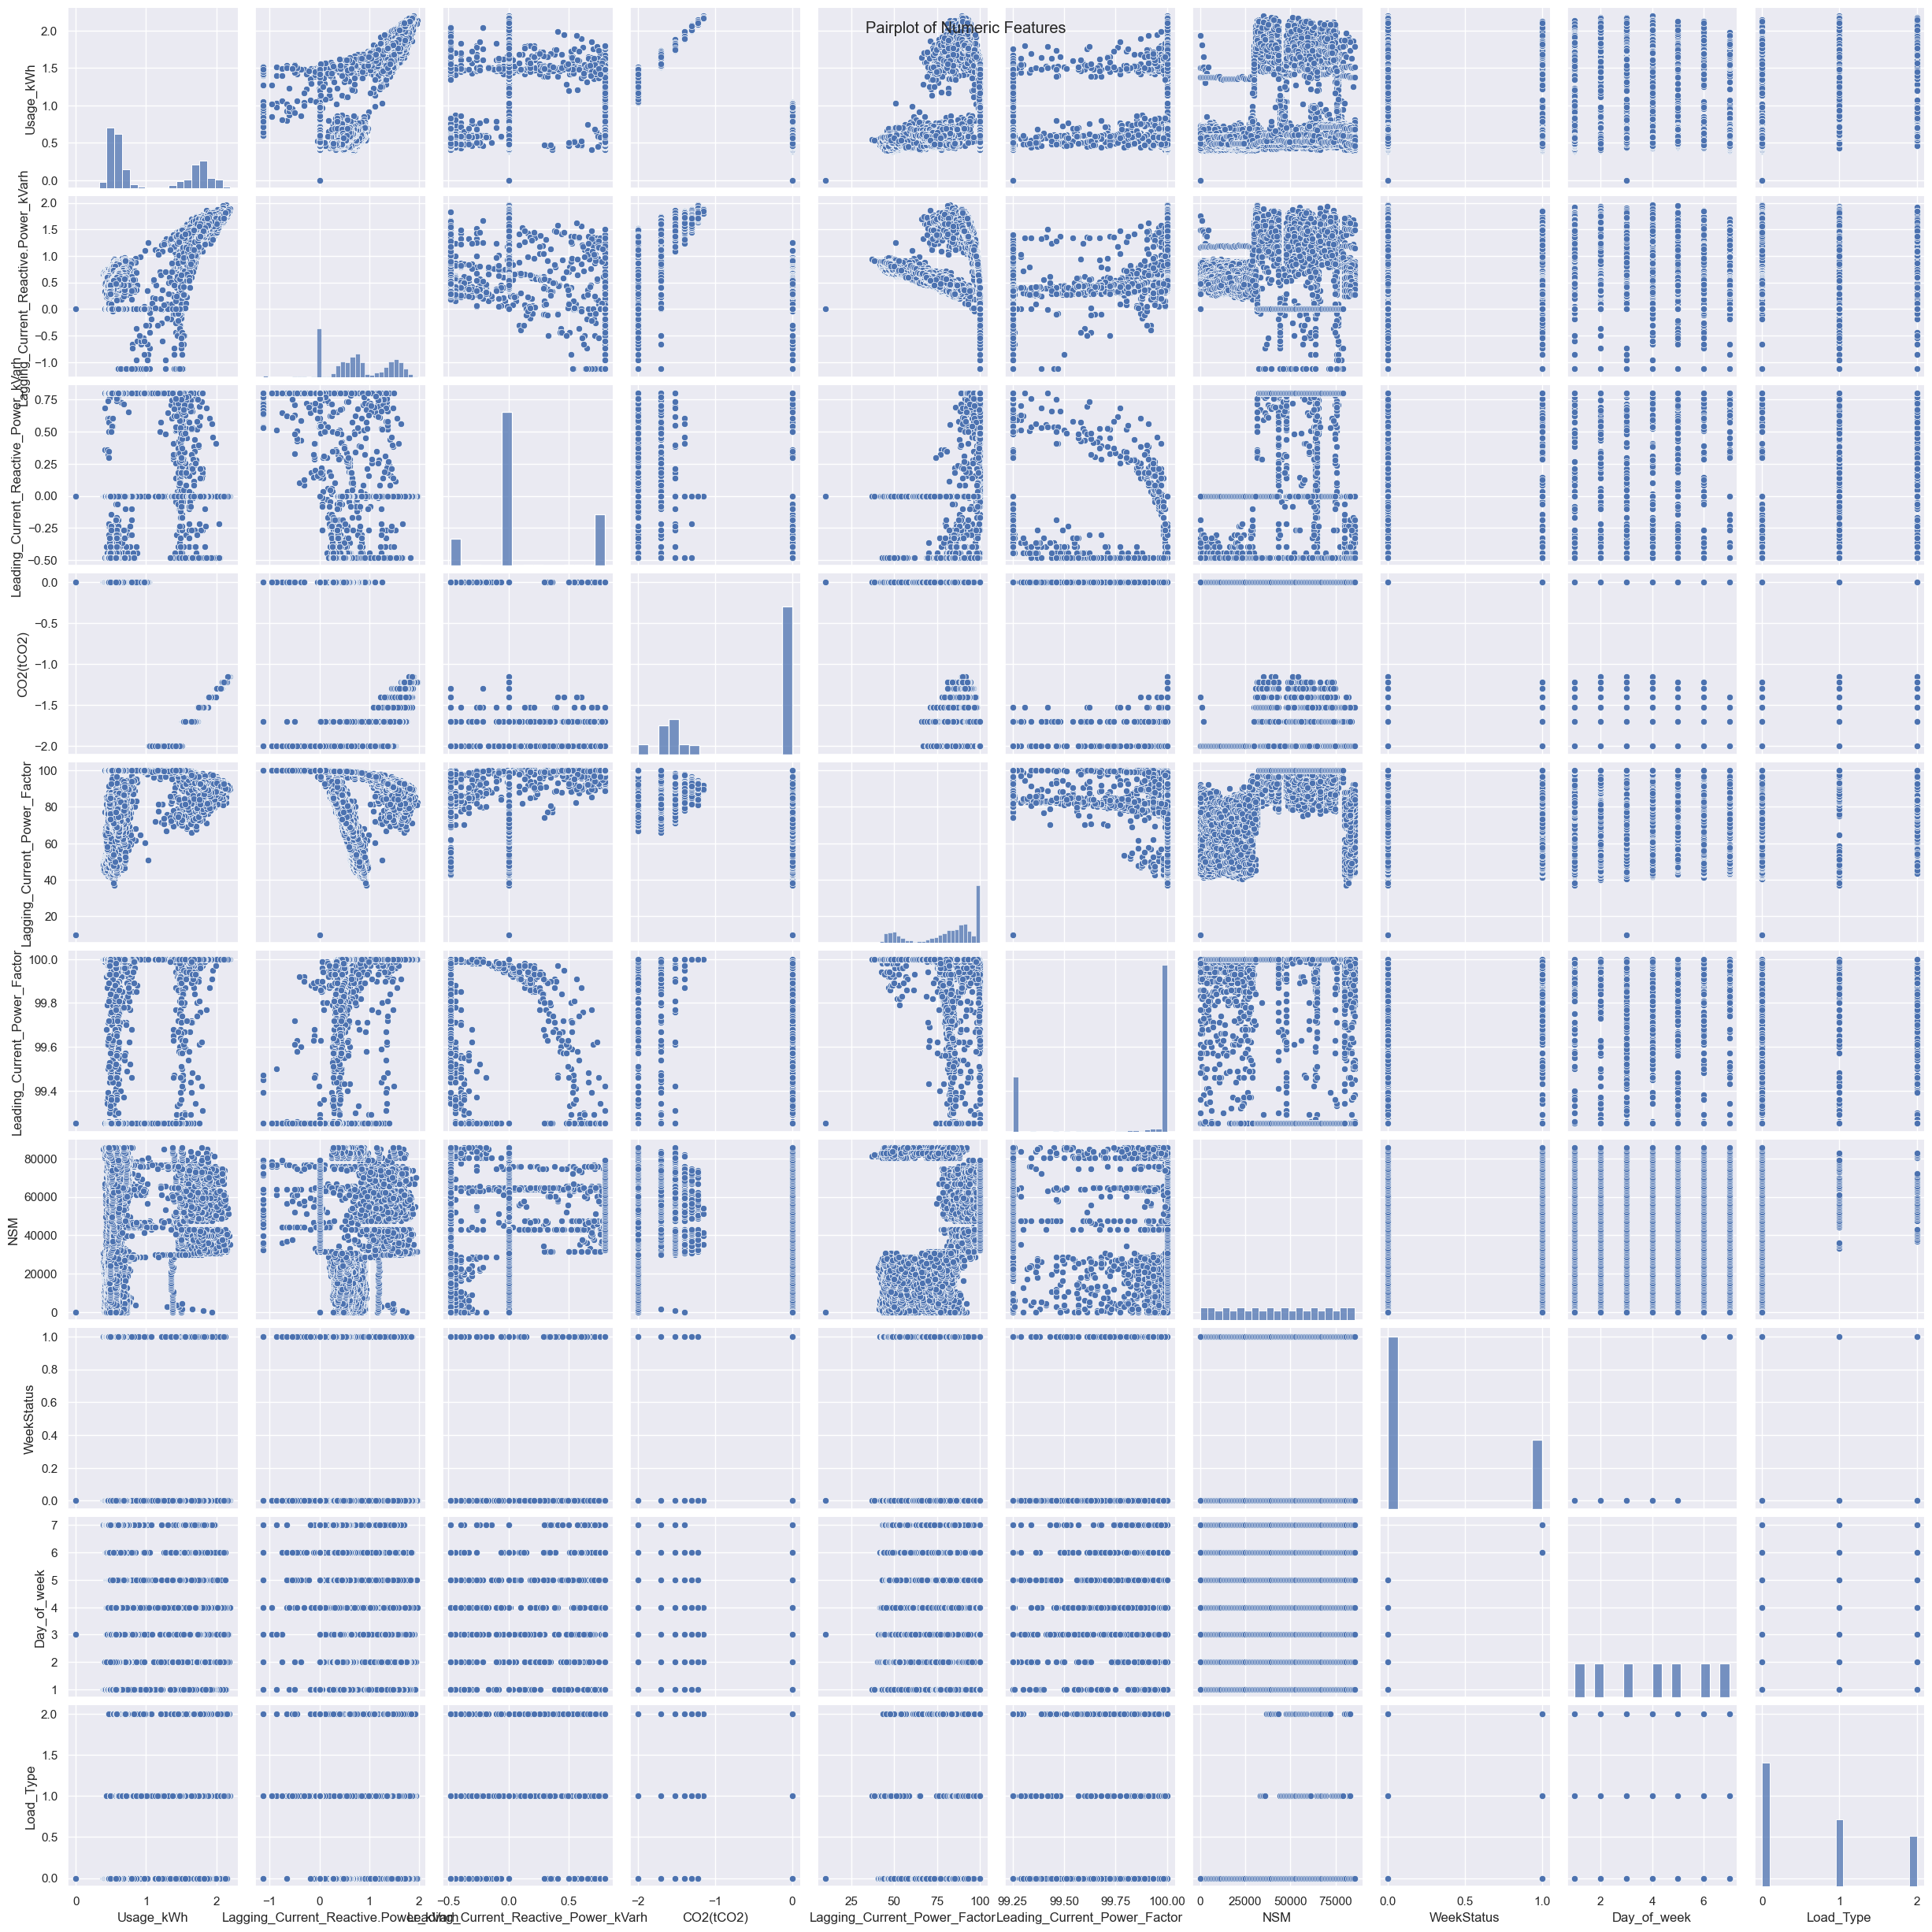

In [127]:
plot_date_range_data(x, '01/10/2018', '31/12/2018')

In [259]:
x.columns

Index(['date', 'Usage_kWh', 'Lagging_Current_Reactive.Power_kVarh',
       'Leading_Current_Reactive_Power_kVarh', 'CO2(tCO2)',
       'Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor', 'NSM',
       'WeekStatus', 'Day_of_week', 'Load_Type'],
      dtype='object')

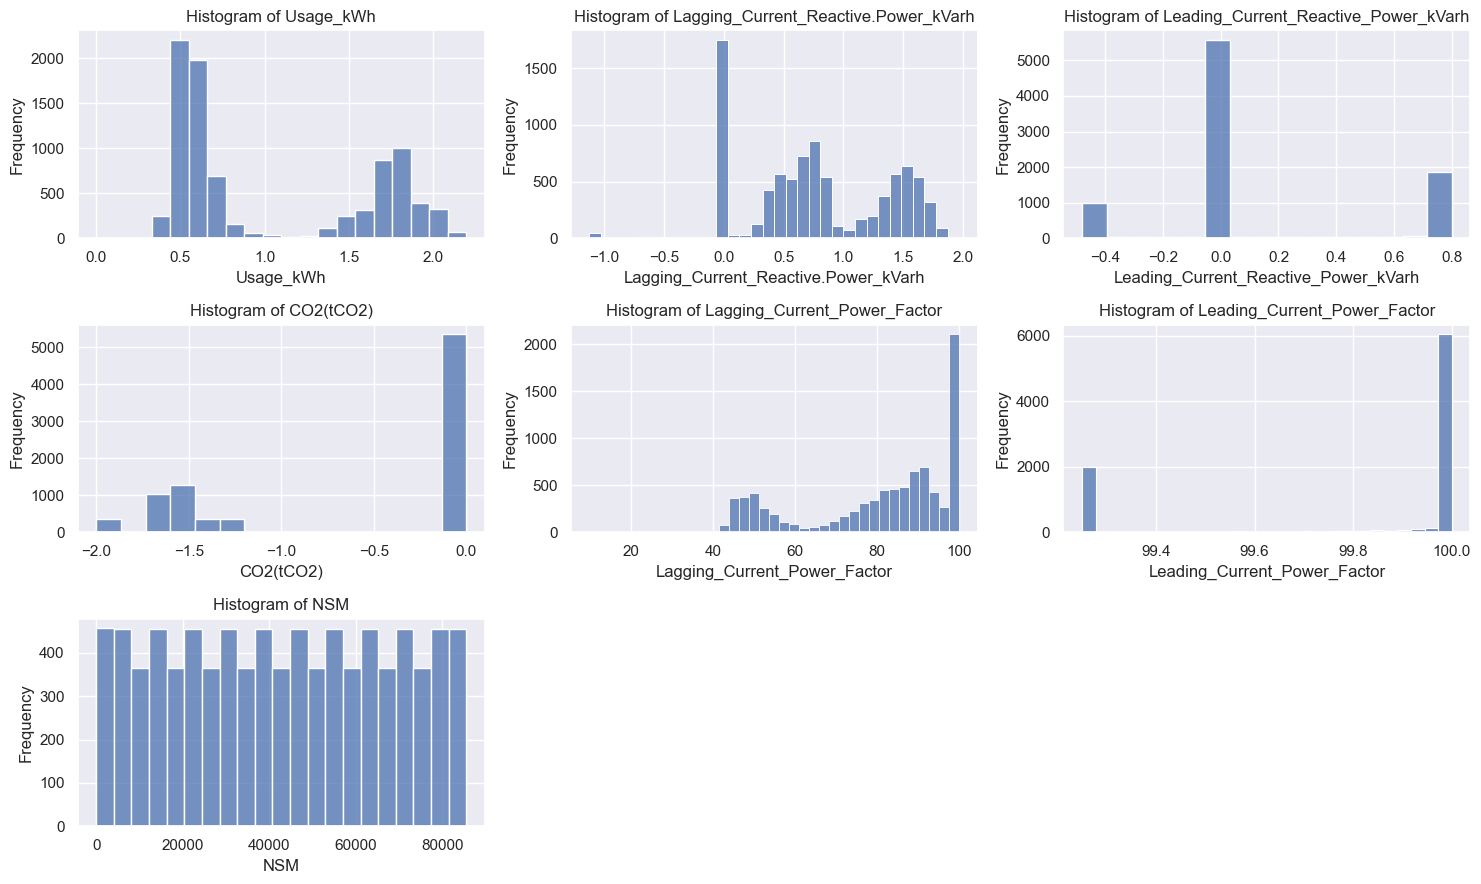

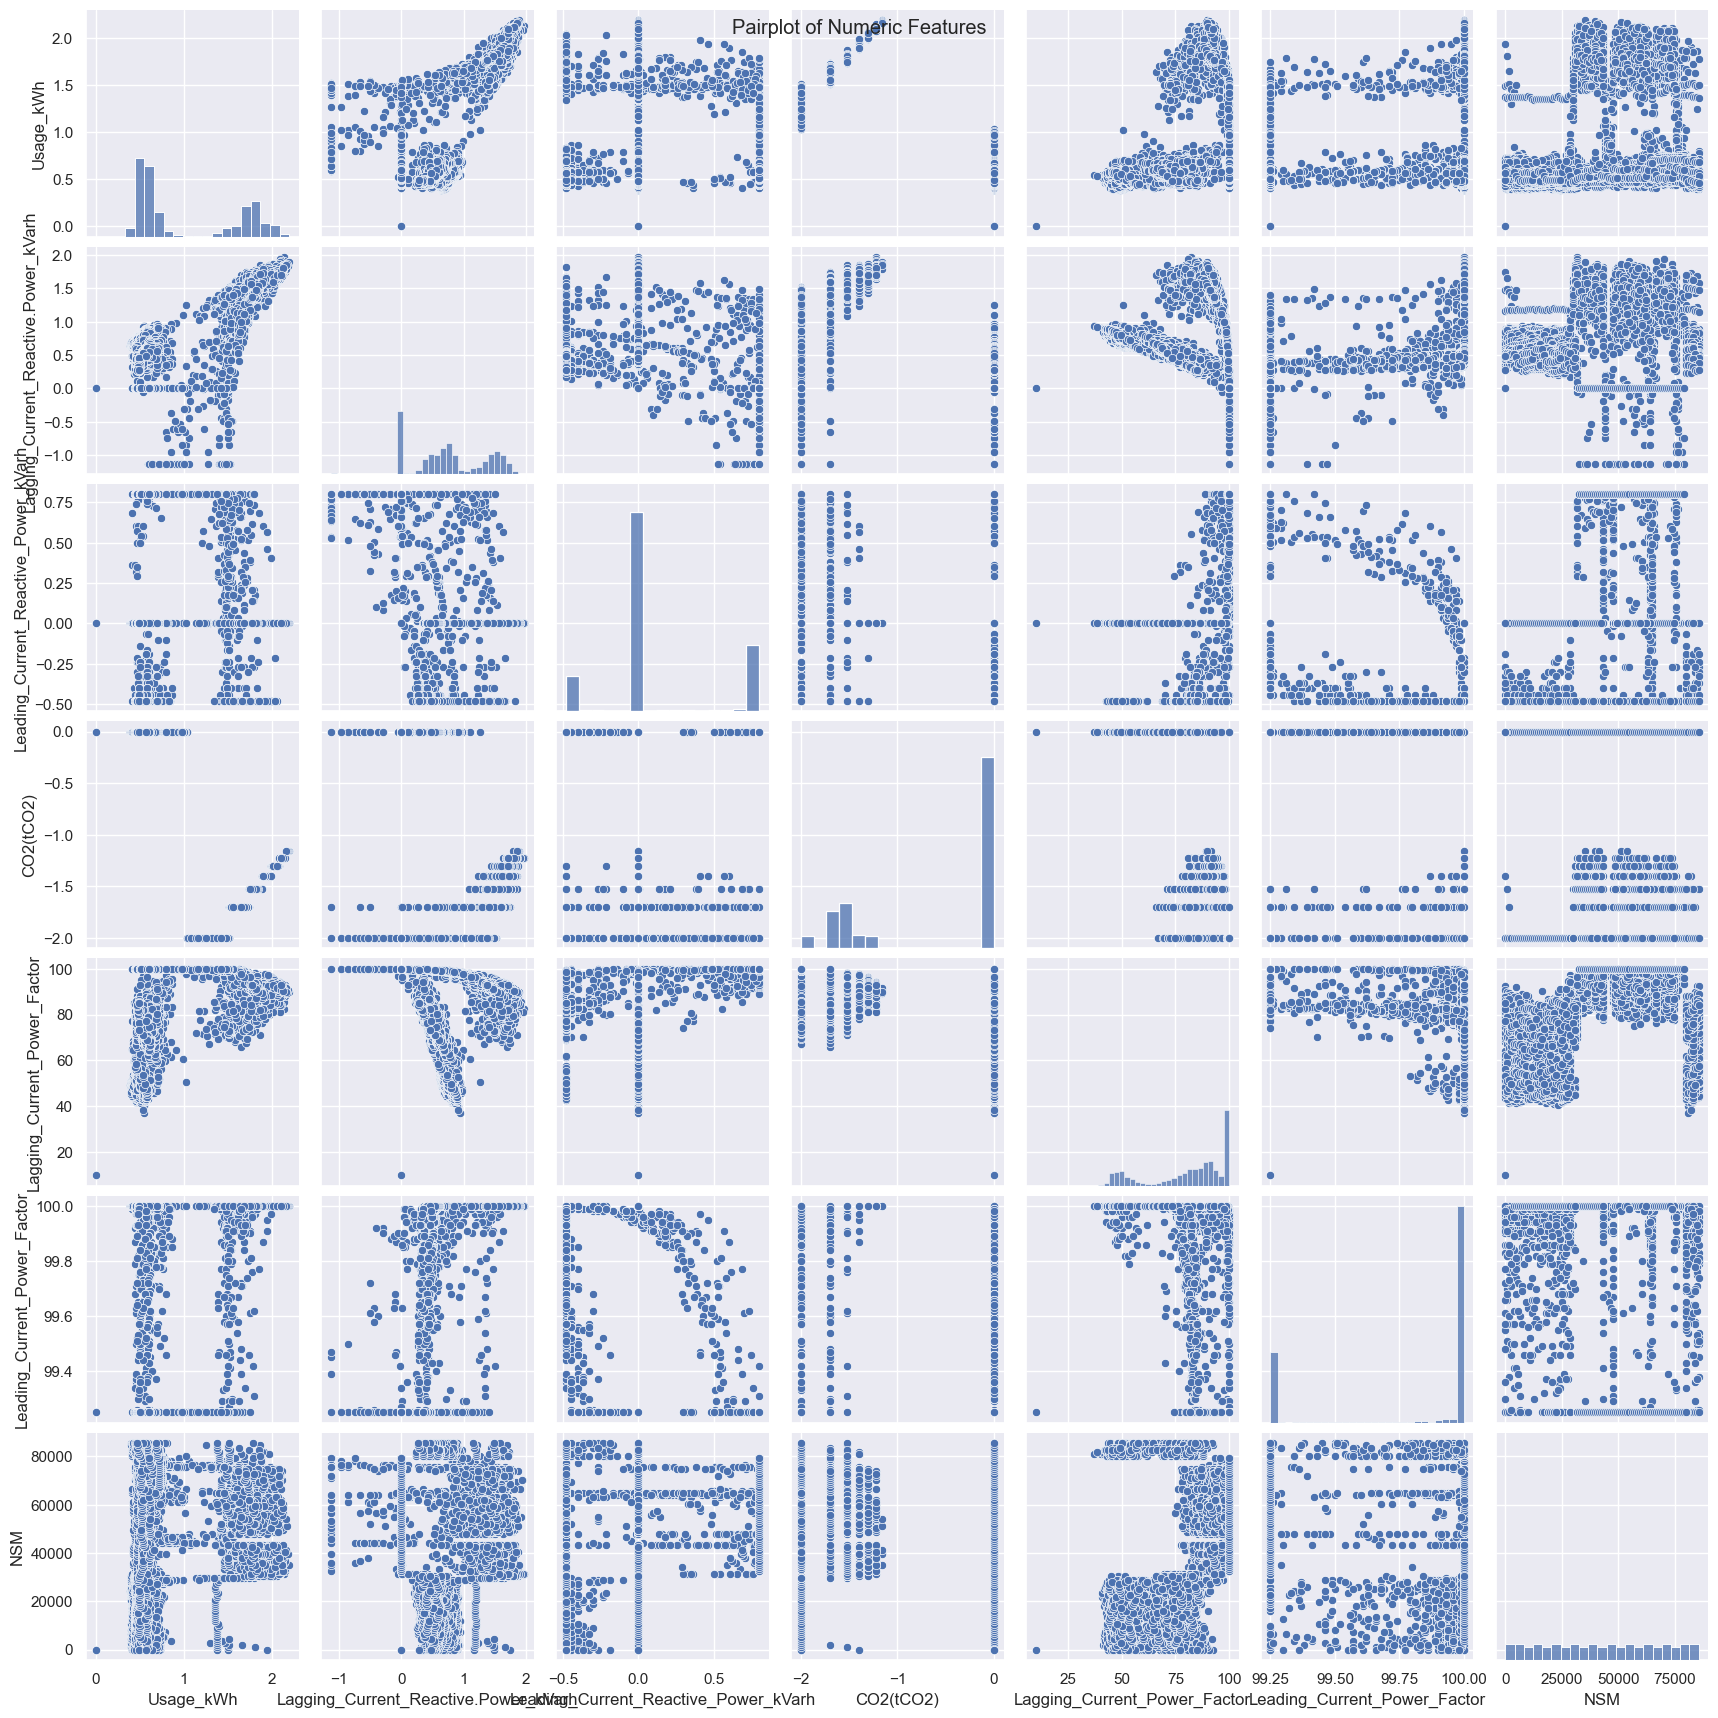

In [260]:
plot_date_range_data(x.drop(columns=['WeekStatus', 'Day_of_week', 'Load_Type']), '01/10/2018', '31/12/2018')


In [128]:
x.head(2)

date  Usage_kWh  Lagging_Current_Reactive.Power_kVarh  \
0 2018-01-01 00:15:00       0.50                                  0.47   
1 2018-01-01 00:30:00       0.60                                  0.65   

   Leading_Current_Reactive_Power_kVarh  CO2(tCO2)  \
0                                  0.00       0.00   
1                                  0.00       0.00   

   Lagging_Current_Power_Factor  Leading_Current_Power_Factor   NSM  \
0                         73.21                        100.00   900   
1                         66.77                        100.00  1800   

   WeekStatus  Day_of_week  Load_Type  
0           0            1          0  
1           0            1          0

In [129]:
x['season'] = x['date'].dt.month.apply(lambda month: (month % 12 // 3 + 1) % 4)

In [130]:
x.head(2)

date  Usage_kWh  Lagging_Current_Reactive.Power_kVarh  \
0 2018-01-01 00:15:00       0.50                                  0.47   
1 2018-01-01 00:30:00       0.60                                  0.65   

   Leading_Current_Reactive_Power_kVarh  CO2(tCO2)  \
0                                  0.00       0.00   
1                                  0.00       0.00   

   Lagging_Current_Power_Factor  Leading_Current_Power_Factor   NSM  \
0                         73.21                        100.00   900   
1                         66.77                        100.00  1800   

   WeekStatus  Day_of_week  Load_Type  season  
0           0            1          0       1  
1           0            1          0       1

In [131]:
x2 = x.copy(deep=True)

In [132]:
x2.drop(columns=['date'], inplace=True)

In [133]:
x2.to_csv('./'+'first_pass'+'.csv',index = False)

In [150]:
x2.head()

Usage_kWh  Lagging_Current_Reactive.Power_kVarh  \
0       0.50                                  0.47   
1       0.60                                  0.65   
2       0.51                                  0.52   
3       0.52                                  0.55   
4       0.58                                  0.65   

   Leading_Current_Reactive_Power_kVarh  CO2(tCO2)  \
0                                  0.00       0.00   
1                                  0.00       0.00   
2                                  0.00       0.00   
3                                  0.00       0.00   
4                                  0.00       0.00   

   Lagging_Current_Power_Factor  Leading_Current_Power_Factor   NSM  \
0                         73.21                        100.00   900   
1                         66.77                        100.00  1800   
2                         70.28                        100.00  2700   
3                         68.09                        100.00  3600   
4                         64.72                        100.00  4500   

   WeekStatus  Day_of_week  Load_Type  season  
0           0            1          0       1  
1           0            1          0       1  
2           0            1          0       1  
3           0            1          0       1  
4           0            1          0       1

# Machine learning

Can't really decide which to predict btw kWh and load on so will do reg first

In [191]:
x = pd.read_csv('first_pass.csv')

In [192]:
x.head(2)

Usage_kWh  Lagging_Current_Reactive.Power_kVarh  \
0       0.50                                  0.47   
1       0.60                                  0.65   

   Leading_Current_Reactive_Power_kVarh  CO2(tCO2)  \
0                                  0.00       0.00   
1                                  0.00       0.00   

   Lagging_Current_Power_Factor  Leading_Current_Power_Factor   NSM  \
0                         73.21                        100.00   900   
1                         66.77                        100.00  1800   

   WeekStatus  Day_of_week  Load_Type  season  
0           0            1          0       1  
1           0            1          0       1

In [193]:
def corr_plot_only_high(x,r=.70):
    '''
    Correlation plot for only high corr features
    '''
    cols = list(x.columns)
    sns.set_theme(rc={"figure.figsize":(16,8)})
    df = pd.get_dummies(x[cols[:25]])
    sns.heatmap(df.corr()[(df.corr()<-r) | (df.corr()>r)], vmin=-1, annot=True)

def corr_plot(x):
    '''
    Creates a correlation plot heatmap to visualize 
    relationships between features that may be too high
    '''
    cols = list(x.columns)
    plt.figure(figsize=(16,8))
    sns.heatmap(pd.get_dummies(x[cols[:25]]).corr(), vmin = -1, annot = True)
    plt.show()

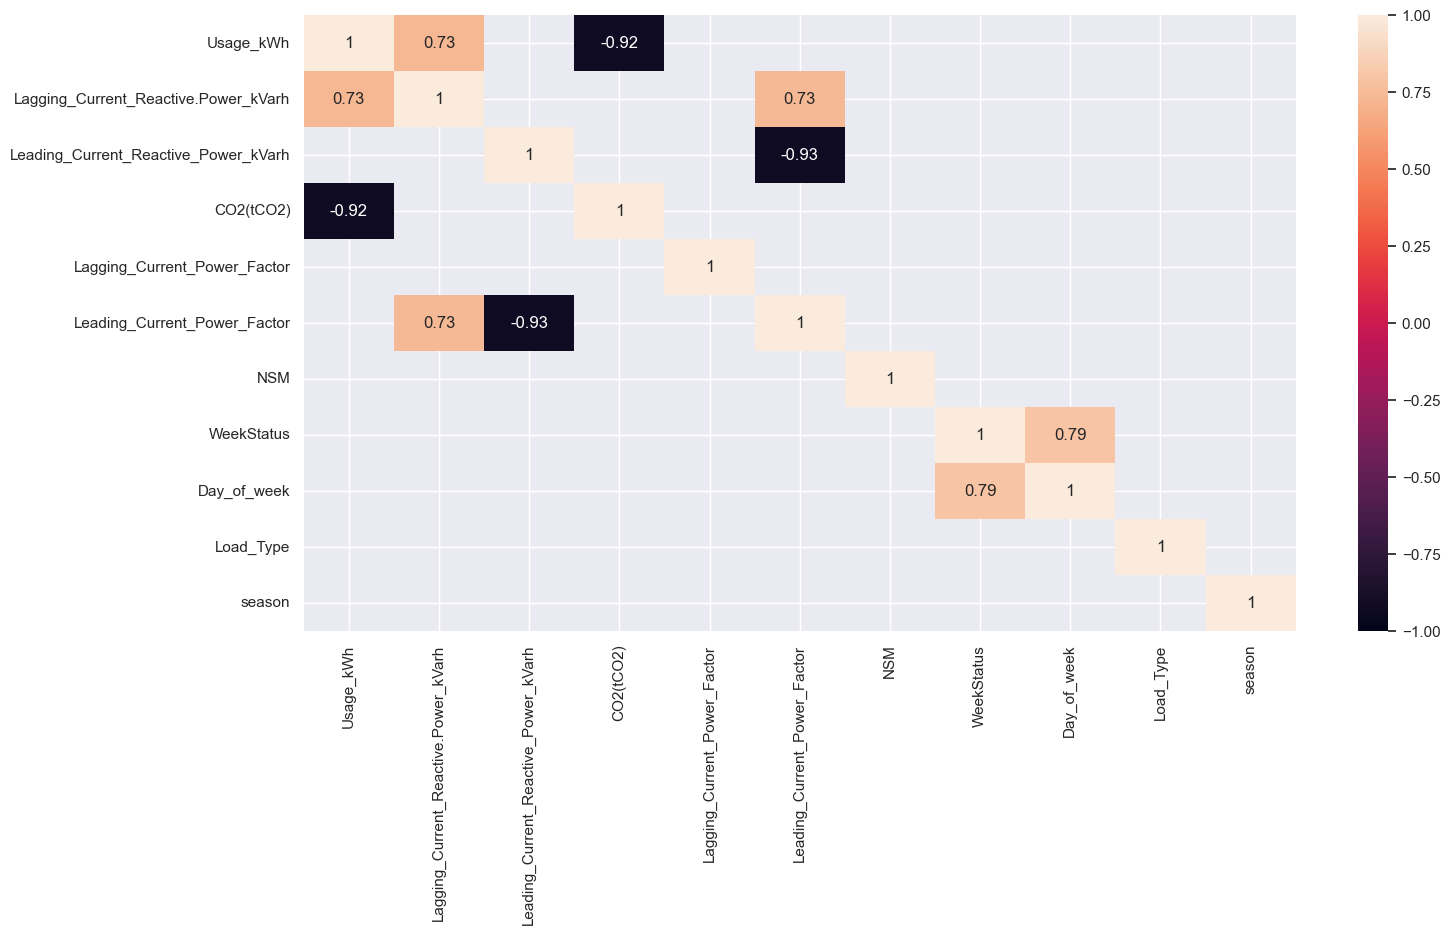

In [194]:
corr_plot_only_high(x)

In [195]:
reg_target = x['Usage_kWh']
x_reg = x.copy(deep=True)

In [196]:
cls_target = x['Load_Type']
x_cls = x.copy(deep=True)

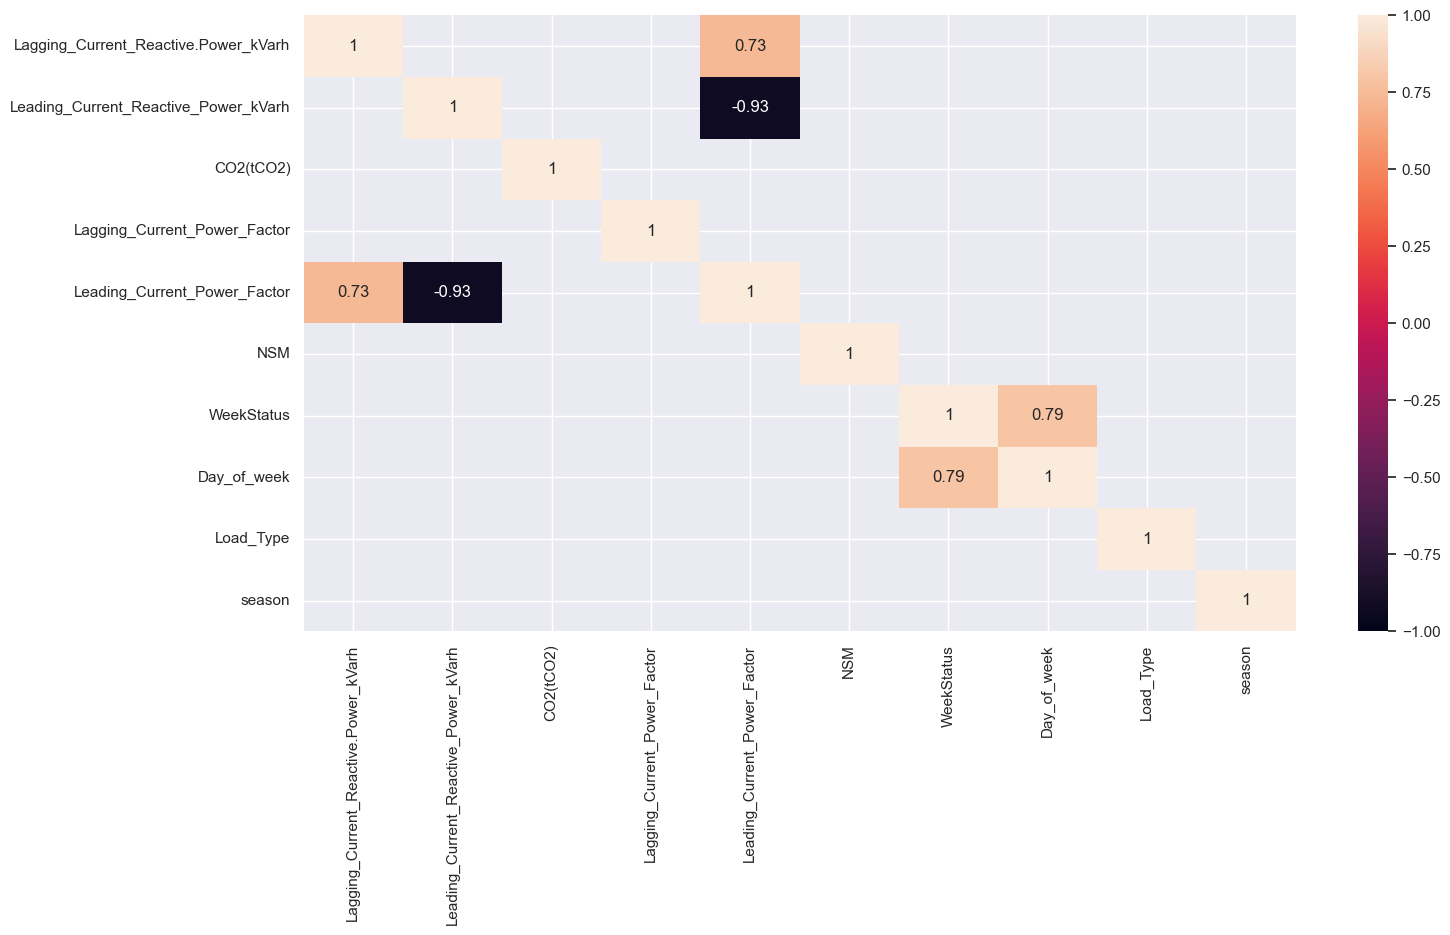

In [197]:
corr_plot_only_high(x_reg.drop(columns = ['Usage_kWh']))

In [198]:
x_reg.columns

Index(['Usage_kWh', 'Lagging_Current_Reactive.Power_kVarh',
       'Leading_Current_Reactive_Power_kVarh', 'CO2(tCO2)',
       'Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor', 'NSM',
       'WeekStatus', 'Day_of_week', 'Load_Type', 'season'],
      dtype='object')

In [199]:
x_reg.drop(columns=['Lagging_Current_Power_Factor'], inplace= True)

In [200]:
x_reg.head(2)

Usage_kWh  Lagging_Current_Reactive.Power_kVarh  \
0       0.50                                  0.47   
1       0.60                                  0.65   

   Leading_Current_Reactive_Power_kVarh  CO2(tCO2)  \
0                                  0.00       0.00   
1                                  0.00       0.00   

   Leading_Current_Power_Factor   NSM  WeekStatus  Day_of_week  Load_Type  \
0                        100.00   900           0            1          0   
1                        100.00  1800           0            1          0   

   season  
0       1  
1       1

In [201]:
x_reg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35040 entries, 0 to 35039
Data columns (total 10 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Usage_kWh                             35040 non-null  float64
 1   Lagging_Current_Reactive.Power_kVarh  35040 non-null  float64
 2   Leading_Current_Reactive_Power_kVarh  35040 non-null  float64
 3   CO2(tCO2)                             35040 non-null  float64
 4   Leading_Current_Power_Factor          35040 non-null  float64
 5   NSM                                   35040 non-null  int64  
 6   WeekStatus                            35040 non-null  int64  
 7   Day_of_week                           35040 non-null  int64  
 8   Load_Type                             35040 non-null  int64  
 9   season                                35040 non-null  int64  
dtypes: float64(5), int64(5)
memory usage: 2.7 MB


In [204]:
from sklearn.preprocessing import MinMaxScaler,KBinsDiscretizer,StandardScaler
from sklearn.model_selection import train_test_split as TTS
def refactor(df,test_size=.2,target_column='target',stratify=False,scaler='mms'):
    '''
    Re-initializes train test data with specified parameters and standardized names.
    '''
    df = df.copy(deep=True)
    global target
    if stratify:
        est = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='quantile')
        df[target_column] = est.fit_transform(df[[target_column]])
    target = df[target_column]
    print(len(target))
    print(df.shape)
    df.drop(columns = target_column, inplace=True)

    global X,xt,y,yt
    if stratify:
        X,xt,y,yt = TTS(df, target, test_size = test_size, stratify = target, random_state = 42)
    else:
        X,xt,y,yt = TTS(df, target, test_size = test_size, random_state = 42)
    
    if scaler == 'std':
        sc = StandardScaler()
    elif scaler == 'mms':
        sc = MinMaxScaler()
    else:
        raise Error(f'Wrong input for scaler: {scaler}')
    X[X.columns] = sc.fit_transform(X[X.columns])
    xt[xt.columns] = sc.transform(xt[xt.columns])


In [205]:
refactor(x_reg, target_column='Usage_kWh')

35040
(35040, 10)


In [206]:
from lazypredict.Supervised import LazyRegressor

In [207]:
reg = LazyRegressor(verbose=1, ignore_warnings=False, custom_metric=None)
models, predictions = reg.fit(X, xt, y, yt)
models

  2%|▏         | 1/42 [00:00<00:38,  1.06it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.9706059743318026, 'Adjusted R-Squared': 0.9705681712121951, 'RMSE': 0.104718271269494, 'Time taken': 0.9413352012634277}


 10%|▉         | 4/42 [00:02<00:17,  2.17it/s]

{'Model': 'BaggingRegressor', 'R-Squared': 0.9914435616472013, 'Adjusted R-Squared': 0.9914325573680965, 'RMSE': 0.05649882844340147, 'Time taken': 1.15724515914917}
{'Model': 'BayesianRidge', 'R-Squared': 0.9302043049693325, 'Adjusted R-Squared': 0.9301145420005877, 'RMSE': 0.1613642217453915, 'Time taken': 0.03649091720581055}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.988401148333798, 'Adjusted R-Squared': 0.9883862312624925, 'RMSE': 0.06578099325110831, 'Time taken': 0.16232895851135254}
{'Model': 'DummyRegressor', 'R-Squared': -0.0001136860071064838, 'Adjusted R-Squared': -0.0013999139542433259, 'RMSE': 0.6108261407823811, 'Time taken': 0.015047550201416016}
{'Model': 'ElasticNet', 'R-Squared': 0.11457795231853618, 'Adjusted R-Squared': 0.11343922719290989, 'RMSE': 0.5747355956919897, 'Time taken': 0.025235652923583984}


 17%|█▋        | 7/42 [00:02<00:08,  3.91it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 0.9301724448805838, 'Adjusted R-Squared': 0.9300826409371608, 'RMSE': 0.16140104702424293, 'Time taken': 0.2692446708679199}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.9879161392764148, 'Adjusted R-Squared': 0.987900598443818, 'RMSE': 0.06714223365816811, 'Time taken': 0.08507299423217773}


 21%|██▏       | 9/42 [00:09<00:45,  1.37s/it]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.9914098868584241, 'Adjusted R-Squared': 0.9913988392707885, 'RMSE': 0.05660989789495711, 'Time taken': 6.719934463500977}
GammaRegressor model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfGammaLoss'.


 26%|██▌       | 11/42 [00:59<04:49,  9.34s/it]

GaussianProcessRegressor model failed to execute
Unable to allocate 2.93 GiB for an array with shape (392882496,) and data type float64


 29%|██▊       | 12/42 [01:02<04:00,  8.01s/it]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.9895791199430227, 'Adjusted R-Squared': 0.9895657178394913, 'RMSE': 0.06235124478362827, 'Time taken': 2.3559625148773193}


 31%|███       | 13/42 [01:04<03:13,  6.69s/it]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.9922687960467103, 'Adjusted R-Squared': 0.992258853086496, 'RMSE': 0.05370521934986026, 'Time taken': 1.8862674236297607}


 36%|███▌      | 15/42 [01:04<01:45,  3.91s/it]

{'Model': 'HuberRegressor', 'R-Squared': 0.9292331862439271, 'Adjusted R-Squared': 0.9291421743371245, 'RMSE': 0.16248293324252228, 'Time taken': 0.20702791213989258}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.9888293933546652, 'Adjusted R-Squared': 0.9888150270414603, 'RMSE': 0.06455521161634759, 'Time taken': 0.19443368911743164}


 40%|████      | 17/42 [14:37<1:05:57, 158.32s/it]

{'Model': 'KernelRidge', 'R-Squared': -1.9465453131533894, 'Adjusted R-Squared': -1.9503348112697623, 'RMSE': 1.0484542673512145, 'Time taken': 812.8984382152557}
{'Model': 'Lars', 'R-Squared': 0.9302049299823054, 'Adjusted R-Squared': 0.9301151678173785, 'RMSE': 0.1613634992441133, 'Time taken': 0.07671046257019043}
{'Model': 'LarsCV', 'R-Squared': 0.9302032364484785, 'Adjusted R-Squared': 0.9301134721055285, 'RMSE': 0.16136545692455284, 'Time taken': 0.09602642059326172}


 45%|████▌     | 19/42 [14:37<34:01, 88.76s/it]   

{'Model': 'Lasso', 'R-Squared': -0.0001136860071064838, 'Adjusted R-Squared': -0.0013999139542433259, 'RMSE': 0.6108261407823811, 'Time taken': 0.041002511978149414}


 55%|█████▍    | 23/42 [14:38<10:35, 33.43s/it]

{'Model': 'LassoCV', 'R-Squared': 0.930184635553735, 'Adjusted R-Squared': 0.930094847288514, 'RMSE': 0.16138695750549004, 'Time taken': 0.3161020278930664}
{'Model': 'LassoLars', 'R-Squared': -0.0001136860071064838, 'Adjusted R-Squared': -0.0013999139542433259, 'RMSE': 0.6108261407823811, 'Time taken': 0.018393993377685547}
{'Model': 'LassoLarsCV', 'R-Squared': 0.9302032364484785, 'Adjusted R-Squared': 0.9301134721055285, 'RMSE': 0.16136545692455284, 'Time taken': 0.06961345672607422}
{'Model': 'LassoLarsIC', 'R-Squared': 0.9302050765522805, 'Adjusted R-Squared': 0.9301153145758544, 'RMSE': 0.161363329811971, 'Time taken': 0.03953433036804199}
{'Model': 'LinearRegression', 'R-Squared': 0.9302049299823052, 'Adjusted R-Squared': 0.9301151678173782, 'RMSE': 0.16136349924411353, 'Time taken': 0.020981311798095703}


 60%|█████▉    | 25/42 [14:38<06:25, 22.67s/it]

{'Model': 'LinearSVR', 'R-Squared': 0.9280896199526361, 'Adjusted R-Squared': 0.9279971373261104, 'RMSE': 0.1637905048597728, 'Time taken': 0.615403413772583}


 62%|██████▏   | 26/42 [14:42<05:05, 19.09s/it]

{'Model': 'MLPRegressor', 'R-Squared': 0.9877309016692785, 'Adjusted R-Squared': 0.987715122605978, 'RMSE': 0.06765489948063365, 'Time taken': 3.7008042335510254}


 71%|███████▏  | 30/42 [15:25<02:32, 12.68s/it]

{'Model': 'NuSVR', 'R-Squared': 0.9899915265564854, 'Adjusted R-Squared': 0.989978654841568, 'RMSE': 0.06110501430862645, 'Time taken': 43.01437067985535}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.8550266964753928, 'Adjusted R-Squared': 0.8548402489572845, 'RMSE': 0.23256103267357903, 'Time taken': 0.025675535202026367}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.9296614588943826, 'Adjusted R-Squared': 0.9295709977812144, 'RMSE': 0.1619905230597105, 'Time taken': 0.0685279369354248}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.9096101141404984, 'Adjusted R-Squared': 0.9094938653590272, 'RMSE': 0.1836338960775957, 'Time taken': 0.041983842849731445}
{'Model': 'PoissonRegressor', 'R-Squared': 0.8156588744205958, 'Adjusted R-Squared': 0.8154217966654923, 'RMSE': 0.26224308607283114, 'Time taken': 0.045516014099121094}


 76%|███████▌  | 32/42 [15:38<01:46, 10.68s/it]

QuantileRegressor model failed to execute
Unable to allocate 11.7 GiB for an array with shape (28032, 56084) and data type float64


 79%|███████▊  | 33/42 [15:38<01:19,  8.81s/it]

{'Model': 'RANSACRegressor', 'R-Squared': 0.9135788732514787, 'Adjusted R-Squared': 0.9134677286186212, 'RMSE': 0.17955722781262204, 'Time taken': 0.34987950325012207}


 88%|████████▊ | 37/42 [15:51<00:25,  5.09s/it]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.9918535336024179, 'Adjusted R-Squared': 0.9918430565807577, 'RMSE': 0.05512867630982709, 'Time taken': 12.471546411514282}
{'Model': 'Ridge', 'R-Squared': 0.9302043635255568, 'Adjusted R-Squared': 0.9301146006321201, 'RMSE': 0.16136415405581878, 'Time taken': 0.03476142883300781}
{'Model': 'RidgeCV', 'R-Squared': 0.9302043635132844, 'Adjusted R-Squared': 0.930114600619832, 'RMSE': 0.16136415407000526, 'Time taken': 0.04501080513000488}
{'Model': 'SGDRegressor', 'R-Squared': 0.9301188279289734, 'Adjusted R-Squared': 0.930028955029768, 'RMSE': 0.161463000872862, 'Time taken': 0.02971625328063965}


 93%|█████████▎| 39/42 [15:55<00:12,  4.12s/it]

{'Model': 'SVR', 'R-Squared': 0.9882387376193026, 'Adjusted R-Squared': 0.9882236116745432, 'RMSE': 0.06623993519776582, 'Time taken': 3.906433343887329}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.9302049299823052, 'Adjusted R-Squared': 0.9301151678173782, 'RMSE': 0.16136349924411353, 'Time taken': 0.027013540267944336}
{'Model': 'TweedieRegressor', 'R-Squared': 0.8102870835506503, 'Adjusted R-Squared': 0.8100430972334105, 'RMSE': 0.2660365944661967, 'Time taken': 0.026983261108398438}


 98%|█████████▊| 41/42 [15:55<00:02,  2.99s/it]

{'Model': 'XGBRegressor', 'R-Squared': 0.9928063429123068, 'Adjusted R-Squared': 0.9927970912812996, 'RMSE': 0.05180453686163207, 'Time taken': 0.8019890785217285}
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000991 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 626
[LightGBM] [Info] Number of data points in the train set: 28032, number of used features: 9
[LightGBM] [Info] Start training from score 1.036138


100%|██████████| 42/42 [15:56<00:00, 22.76s/it]

{'Model': 'LGBMRegressor', 'R-Squared': 0.9923967737246908, 'Adjusted R-Squared': 0.992386995354231, 'RMSE': 0.053258862589136584, 'Time taken': 0.26021385192871094}


Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
XGBRegressor                                 0.99       0.99  0.05        0.80
LGBMRegressor                                0.99       0.99  0.05        0.26
HistGradientBoostingRegressor                0.99       0.99  0.05        1.89
RandomForestRegressor                        0.99       0.99  0.06       12.47
BaggingRegressor                             0.99       0.99  0.06        1.16
ExtraTreesRegressor                          0.99       0.99  0.06        6.72
NuSVR                                        0.99       0.99  0.06       43.01
GradientBoostingRegressor                    0.99       0.99  0.06        2.36
KNeighborsRegressor                          0.99       0.99  0.06        0.19
DecisionTreeRegressor                        0.99       0.99  0.07        0.16
SVR                                          0.99       0.99  0.07        3.91
ExtraTreeRegressor                           0.99       0.99  0.07        0.09
MLPRegressor                                 0.99       0.99  0.07        3.70
AdaBoostRegressor                            0.97       0.97  0.10        0.94
LassoLarsIC                                  0.93       0.93  0.16        0.04
Lars                                         0.93       0.93  0.16        0.08
TransformedTargetRegressor                   0.93       0.93  0.16        0.03
LinearRegression                             0.93       0.93  0.16        0.02
Ridge                                        0.93       0.93  0.16        0.03
RidgeCV                                      0.93       0.93  0.16        0.05
BayesianRidge                                0.93       0.93  0.16        0.04
LarsCV                                       0.93       0.93  0.16        0.10
LassoLarsCV                                  0.93       0.93  0.16        0.07
LassoCV                                      0.93       0.93  0.16        0.32
ElasticNetCV                                 0.93       0.93  0.16        0.27
SGDRegressor                                 0.93       0.93  0.16        0.03
OrthogonalMatchingPursuitCV                  0.93       0.93  0.16        0.07
HuberRegressor                               0.93       0.93  0.16        0.21
LinearSVR                                    0.93       0.93  0.16        0.62
RANSACRegressor                              0.91       0.91  0.18        0.35
PassiveAggressiveRegressor                   0.91       0.91  0.18        0.04
OrthogonalMatchingPursuit                    0.85       0.86  0.23        0.03
PoissonRegressor                             0.82       0.82  0.26        0.05
TweedieRegressor                             0.81       0.81  0.27        0.03
ElasticNet                                   0.11       0.11  0.57        0.03
LassoLars                                   -0.00      -0.00  0.61        0.02
DummyRegressor                              -0.00      -0.00  0.61        0.02
Lasso                                       -0.00      -0.00  0.61        0.04
KernelRidge                                 -1.95      -1.95  1.05      812.90

In [272]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import joblib

In [273]:
model = xgb.XGBRegressor(objective='reg:squarederror')
model.fit(X, y)
y_pred = model.predict(xt)
mse = mean_squared_error(yt, y_pred)
print(f'Mean Squared Error: {mse}')


Mean Squared Error: 0.002683710039448196


In [276]:
joblib_filename = 'xgb_model.joblib'
joblib.dump(model, joblib_filename)
print(f'Model saved as {joblib_filename}')

Model saved as xgb_model.joblib


In [277]:
xgb_model = joblib.load('xgb_model.joblib')

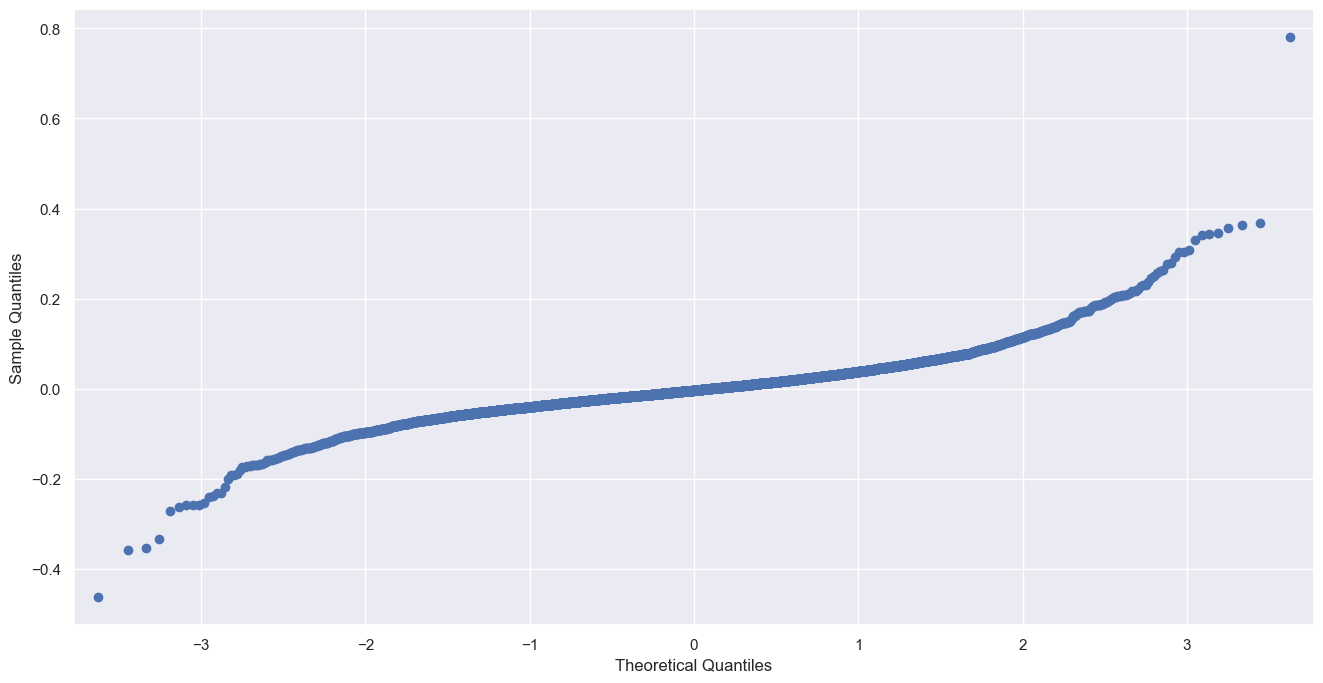

In [278]:
# Q-Q plot
res = yt - xgb_model.predict(xt)
sm.qqplot(res)
plt.show()

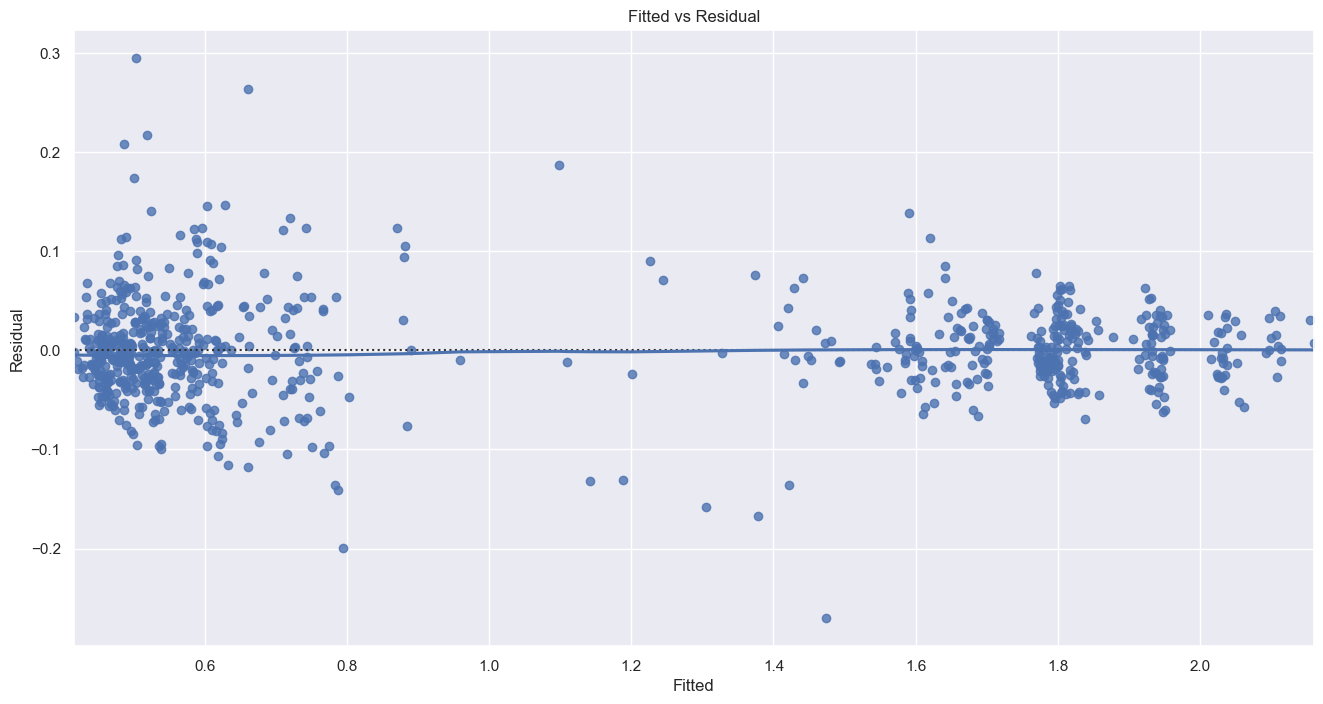

In [281]:
# Prediction
pred = xgb_model.predict(xt)

# Visualization of residuals
sns.residplot(x = pred[:800], y = yt[:800], lowess = True)
plt.xlabel('Fitted')
plt.ylabel('Residual')
plt.title('Fitted vs Residual')
plt.show()

In [ ]:
from xgboost import xgbregressor

In [ ]:
import joblib

In [ ]:
joblib.dump(rfg, 'regression_steel.pkl')

In [ ]:
rg = joblib.load('regression_steel.pkl')

In [ ]:
# Predicting the target values of the train set
y_pred_train = rfg.predict(X)

# RMSE (Root Mean Square Error)
rmse_train = float(format(np.sqrt(mean_squared_error(y, y_pred_train)), '.3f'))
print("\nRMSE: ", rmse_train)

In [321]:
def refactor_classification(df,test_size=.2,target_column='target',scaler='mms'):
    '''
    Re-initializes train test data with specified parameters and standardized names.
    '''
    df = df.copy(deep=True)
    global target
    target = df[target_column]
    print(len(target))
    print(df.shape)
    df.drop(columns = target_column, inplace=True)


    global X,xt,y,yt
    X,xt,y,yt = TTS(df, target, test_size = test_size, random_state = 42)

    print("Class distribution before SMOTE:")
    print(y.value_counts())

    smote = SMOTE(random_state=42)
    X, y = smote.fit_resample(X, y)


    print("Class distribution after SMOTE:")
    print(y.value_counts())

    
    if scaler == 'std':
        sc = StandardScaler()
    elif scaler == 'mms':
        sc = MinMaxScaler()
    else:
        raise Error(f'Wrong input for scaler: {scaler}')
    X[X.columns] = sc.fit_transform(X[X.columns])
    xt[xt.columns] = sc.transform(xt[xt.columns])

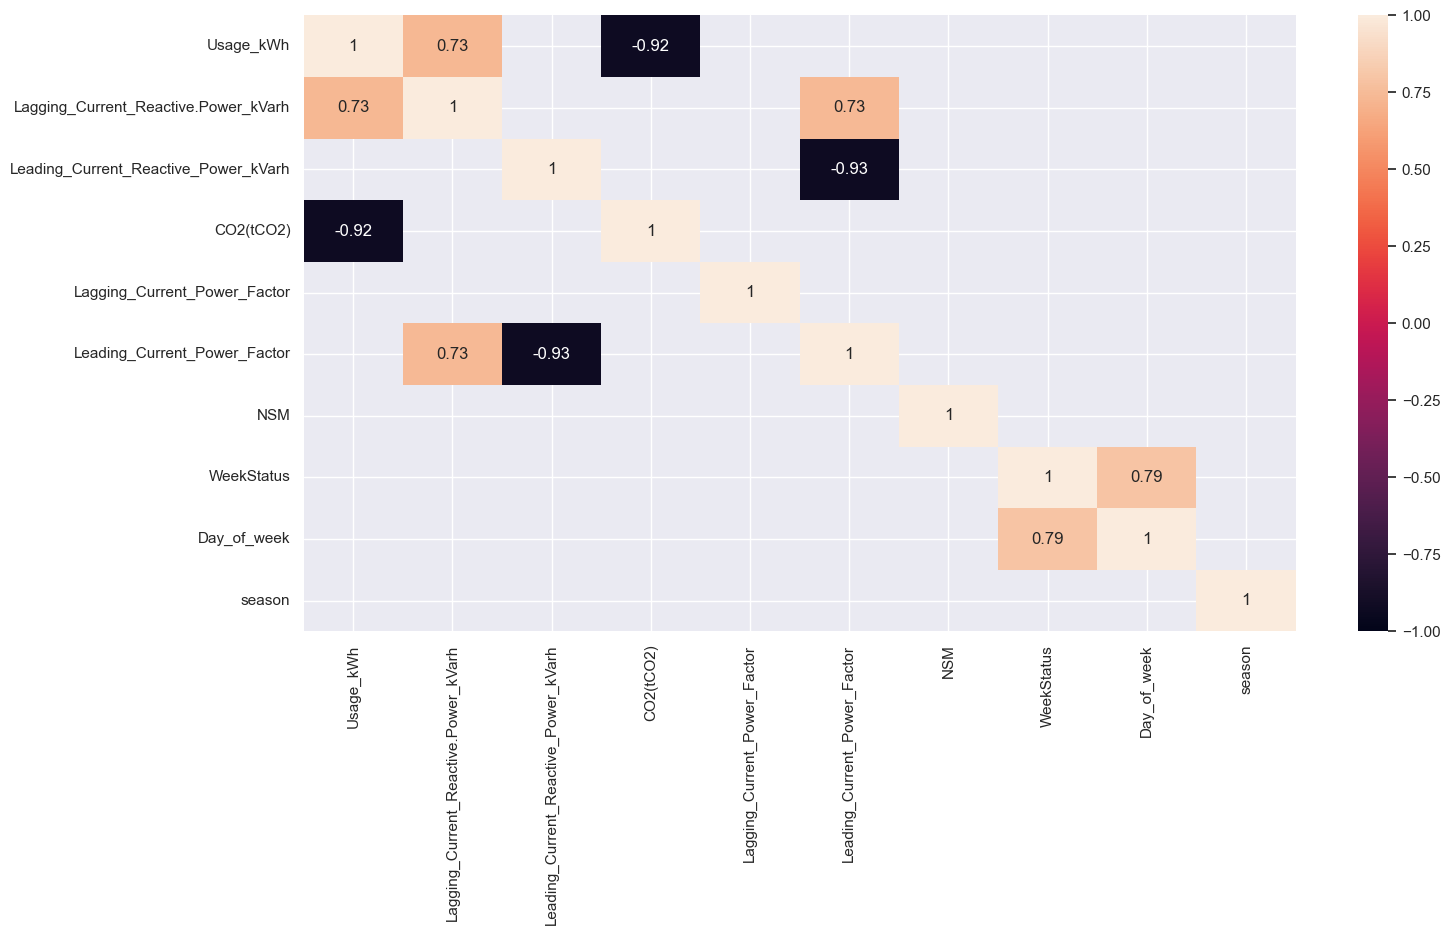

In [303]:
corr_plot_only_high(x_cls.drop(columns = ['Load_Type']))

In [304]:
x_cls.columns

Index(['Usage_kWh', 'Lagging_Current_Reactive.Power_kVarh',
       'Leading_Current_Reactive_Power_kVarh', 'CO2(tCO2)',
       'Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor', 'NSM',
       'WeekStatus', 'Day_of_week', 'Load_Type', 'season'],
      dtype='object')

In [305]:
x_cls = x_cls.drop(columns=['Leading_Current_Power_Factor', 'CO2(tCO2)'])

In [306]:
x_cls.columns

Index(['Usage_kWh', 'Lagging_Current_Reactive.Power_kVarh',
       'Leading_Current_Reactive_Power_kVarh', 'Lagging_Current_Power_Factor',
       'NSM', 'WeekStatus', 'Day_of_week', 'Load_Type', 'season'],
      dtype='object')

In [307]:
from lazypredict.Supervised import LazyClassifier

In [333]:
refactor_classification(x_cls, test_size=.2, target_column='Load_Type')

35040
(35040, 9)
Class distribution before SMOTE:
Load_Type
0    14500
1     7759
2     5773
Name: count, dtype: int64
Class distribution after SMOTE:
Load_Type
1    14500
0    14500
2    14500
Name: count, dtype: int64


In [340]:
cls = LazyClassifier(verbose=1, ignore_warnings=False, custom_metric=None)
models, predictions = cls.fit(X, xt, y, yt)
models

  3%|▎         | 1/29 [00:02<01:02,  2.23s/it]

ROC AUC couldn't be calculated for AdaBoostClassifier
multi_class must be in ('ovo', 'ovr')
{'Model': 'AdaBoostClassifier', 'Accuracy': 0.8624429223744292, 'Balanced Accuracy': 0.8414830629446635, 'ROC AUC': None, 'F1 Score': 0.8612182423986586, 'Time taken': 2.227987051010132}


  7%|▋         | 2/29 [00:03<00:52,  1.93s/it]

ROC AUC couldn't be calculated for BaggingClassifier
multi_class must be in ('ovo', 'ovr')
{'Model': 'BaggingClassifier', 'Accuracy': 0.9534817351598174, 'Balanced Accuracy': 0.9473247388961763, 'ROC AUC': None, 'F1 Score': 0.9534479776194198, 'Time taken': 1.7168991565704346}
ROC AUC couldn't be calculated for BernoulliNB
multi_class must be in ('ovo', 'ovr')
{'Model': 'BernoulliNB', 'Accuracy': 0.6703767123287672, 'Balanced Accuracy': 0.6534332953552935, 'ROC AUC': None, 'F1 Score': 0.6756240319743275, 'Time taken': 0.05309152603149414}


 14%|█▍        | 4/29 [00:04<00:24,  1.02it/s]

ROC AUC couldn't be calculated for CalibratedClassifierCV
multi_class must be in ('ovo', 'ovr')
{'Model': 'CalibratedClassifierCV', 'Accuracy': 0.7448630136986302, 'Balanced Accuracy': 0.7202675667787749, 'ROC AUC': None, 'F1 Score': 0.7493061216300597, 'Time taken': 0.7773382663726807}
CategoricalNB model failed to execute
Negative values in data passed to CategoricalNB (input X)


 21%|██        | 6/29 [00:05<00:13,  1.75it/s]

ROC AUC couldn't be calculated for DecisionTreeClassifier
multi_class must be in ('ovo', 'ovr')
{'Model': 'DecisionTreeClassifier', 'Accuracy': 0.9483447488584474, 'Balanced Accuracy': 0.9414228707539506, 'ROC AUC': None, 'F1 Score': 0.9482799182496441, 'Time taken': 0.20535039901733398}
ROC AUC couldn't be calculated for DummyClassifier
multi_class must be in ('ovo', 'ovr')
{'Model': 'DummyClassifier', 'Accuracy': 0.509703196347032, 'Balanced Accuracy': 0.3333333333333333, 'ROC AUC': None, 'F1 Score': 0.34417009779803365, 'Time taken': 0.03330230712890625}
ROC AUC couldn't be calculated for ExtraTreeClassifier
multi_class must be in ('ovo', 'ovr')
{'Model': 'ExtraTreeClassifier', 'Accuracy': 0.8889840182648402, 'Balanced Accuracy': 0.8680907374984802, 'ROC AUC': None, 'F1 Score': 0.8890750745400212, 'Time taken': 0.05353045463562012}


 31%|███       | 9/29 [00:07<00:15,  1.29it/s]

ROC AUC couldn't be calculated for ExtraTreesClassifier
multi_class must be in ('ovo', 'ovr')
{'Model': 'ExtraTreesClassifier', 'Accuracy': 0.942351598173516, 'Balanced Accuracy': 0.9338045820751727, 'ROC AUC': None, 'F1 Score': 0.9423281857275101, 'Time taken': 2.844254970550537}
ROC AUC couldn't be calculated for GaussianNB
multi_class must be in ('ovo', 'ovr')
{'Model': 'GaussianNB', 'Accuracy': 0.6959189497716894, 'Balanced Accuracy': 0.6790384211718568, 'ROC AUC': None, 'F1 Score': 0.7014737133095612, 'Time taken': 0.038004159927368164}


 48%|████▊     | 14/29 [00:08<00:05,  2.70it/s]

ROC AUC couldn't be calculated for KNeighborsClassifier
multi_class must be in ('ovo', 'ovr')
{'Model': 'KNeighborsClassifier', 'Accuracy': 0.8978310502283106, 'Balanced Accuracy': 0.8859518984464935, 'ROC AUC': None, 'F1 Score': 0.8986724096076018, 'Time taken': 0.3227047920227051}
LabelPropagation model failed to execute
Unable to allocate 14.1 GiB for an array with shape (43500, 43500) and data type float64
LabelSpreading model failed to execute
Unable to allocate 14.1 GiB for an array with shape (43500, 43500) and data type float64
ROC AUC couldn't be calculated for LinearDiscriminantAnalysis
multi_class must be in ('ovo', 'ovr')
{'Model': 'LinearDiscriminantAnalysis', 'Accuracy': 0.7073344748858448, 'Balanced Accuracy': 0.6978634705584095, 'ROC AUC': None, 'F1 Score': 0.7177738006610687, 'Time taken': 0.13704729080200195}


 52%|█████▏    | 15/29 [00:12<00:12,  1.12it/s]

ROC AUC couldn't be calculated for LinearSVC
multi_class must be in ('ovo', 'ovr')
{'Model': 'LinearSVC', 'Accuracy': 0.7417237442922374, 'Balanced Accuracy': 0.7196576621512908, 'ROC AUC': None, 'F1 Score': 0.7463406569693444, 'Time taken': 3.560324192047119}


 55%|█████▌    | 16/29 [00:12<00:10,  1.29it/s]

ROC AUC couldn't be calculated for LogisticRegression
multi_class must be in ('ovo', 'ovr')
{'Model': 'LogisticRegression', 'Accuracy': 0.7559931506849316, 'Balanced Accuracy': 0.7298440814670407, 'ROC AUC': None, 'F1 Score': 0.7596624524897307, 'Time taken': 0.2778608798980713}
ROC AUC couldn't be calculated for NearestCentroid
multi_class must be in ('ovo', 'ovr')
{'Model': 'NearestCentroid', 'Accuracy': 0.6793664383561644, 'Balanced Accuracy': 0.6716691735768426, 'ROC AUC': None, 'F1 Score': 0.6915994722972235, 'Time taken': 0.03012394905090332}


 66%|██████▌   | 19/29 [01:33<01:57, 11.74s/it]

ROC AUC couldn't be calculated for NuSVC
multi_class must be in ('ovo', 'ovr')
{'Model': 'NuSVC', 'Accuracy': 0.7592751141552512, 'Balanced Accuracy': 0.7450170435699636, 'ROC AUC': None, 'F1 Score': 0.7653196740118423, 'Time taken': 80.59847235679626}
ROC AUC couldn't be calculated for PassiveAggressiveClassifier
multi_class must be in ('ovo', 'ovr')
{'Model': 'PassiveAggressiveClassifier', 'Accuracy': 0.651398401826484, 'Balanced Accuracy': 0.6317918966919874, 'ROC AUC': None, 'F1 Score': 0.6672056274738905, 'Time taken': 0.14772939682006836}


 69%|██████▉   | 20/29 [01:33<01:22,  9.15s/it]

ROC AUC couldn't be calculated for Perceptron
multi_class must be in ('ovo', 'ovr')
{'Model': 'Perceptron', 'Accuracy': 0.7126141552511416, 'Balanced Accuracy': 0.6707106121905757, 'ROC AUC': None, 'F1 Score': 0.7245641042517714, 'Time taken': 0.11142206192016602}
ROC AUC couldn't be calculated for QuadraticDiscriminantAnalysis
multi_class must be in ('ovo', 'ovr')
{'Model': 'QuadraticDiscriminantAnalysis', 'Accuracy': 0.7431506849315068, 'Balanced Accuracy': 0.703982463494202, 'ROC AUC': None, 'F1 Score': 0.7304171989600937, 'Time taken': 0.08341598510742188}


 76%|███████▌  | 22/29 [01:41<00:50,  7.27s/it]

ROC AUC couldn't be calculated for RandomForestClassifier
multi_class must be in ('ovo', 'ovr')
{'Model': 'RandomForestClassifier', 'Accuracy': 0.9559075342465754, 'Balanced Accuracy': 0.9509257017570002, 'ROC AUC': None, 'F1 Score': 0.9558992608738361, 'Time taken': 8.513228416442871}
ROC AUC couldn't be calculated for RidgeClassifier
multi_class must be in ('ovo', 'ovr')
{'Model': 'RidgeClassifier', 'Accuracy': 0.7136130136986302, 'Balanced Accuracy': 0.6998845805255248, 'ROC AUC': None, 'F1 Score': 0.7224384965566536, 'Time taken': 0.07831788063049316}


 83%|████████▎ | 24/29 [01:42<00:23,  4.71s/it]

ROC AUC couldn't be calculated for RidgeClassifierCV
multi_class must be in ('ovo', 'ovr')
{'Model': 'RidgeClassifierCV', 'Accuracy': 0.7134703196347032, 'Balanced Accuracy': 0.6997912621231359, 'ROC AUC': None, 'F1 Score': 0.7223095230061305, 'Time taken': 0.1373298168182373}


 86%|████████▌ | 25/29 [01:42<00:15,  3.81s/it]

ROC AUC couldn't be calculated for SGDClassifier
multi_class must be in ('ovo', 'ovr')
{'Model': 'SGDClassifier', 'Accuracy': 0.7267408675799086, 'Balanced Accuracy': 0.710268415933064, 'ROC AUC': None, 'F1 Score': 0.7324042961276164, 'Time taken': 0.2800178527832031}


 90%|████████▉ | 26/29 [02:22<00:35, 11.94s/it]

ROC AUC couldn't be calculated for SVC
multi_class must be in ('ovo', 'ovr')
{'Model': 'SVC', 'Accuracy': 0.8361872146118722, 'Balanced Accuracy': 0.8088326850246214, 'ROC AUC': None, 'F1 Score': 0.8368404842593266, 'Time taken': 39.949973344802856}
StackingClassifier model failed to execute
__init__() missing 1 required positional argument: 'estimators'


 97%|█████████▋| 28/29 [02:22<00:07,  7.35s/it]

ROC AUC couldn't be calculated for XGBClassifier
multi_class must be in ('ovo', 'ovr')
{'Model': 'XGBClassifier', 'Accuracy': 0.9609018264840182, 'Balanced Accuracy': 0.9575739551364042, 'ROC AUC': None, 'F1 Score': 0.9609450051974703, 'Time taken': 0.43359899520874023}
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000828 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1133
[LightGBM] [Info] Number of data points in the train set: 43500, number of used features: 8
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


100%|██████████| 29/29 [02:23<00:00,  4.94s/it]

ROC AUC couldn't be calculated for LGBMClassifier
multi_class must be in ('ovo', 'ovr')
{'Model': 'LGBMClassifier', 'Accuracy': 0.9601883561643836, 'Balanced Accuracy': 0.9566565460958993, 'ROC AUC': None, 'F1 Score': 0.9601964695455213, 'Time taken': 0.422926664352417}


Accuracy  Balanced Accuracy ROC AUC  F1 Score  \
Model                                                                          
XGBClassifier                      0.96               0.96    None      0.96   
LGBMClassifier                     0.96               0.96    None      0.96   
RandomForestClassifier             0.96               0.95    None      0.96   
BaggingClassifier                  0.95               0.95    None      0.95   
DecisionTreeClassifier             0.95               0.94    None      0.95   
ExtraTreesClassifier               0.94               0.93    None      0.94   
KNeighborsClassifier               0.90               0.89    None      0.90   
ExtraTreeClassifier                0.89               0.87    None      0.89   
AdaBoostClassifier                 0.86               0.84    None      0.86   
SVC                                0.84               0.81    None      0.84   
NuSVC                              0.76               0.75    None      0.77   
LogisticRegression                 0.76               0.73    None      0.76   
CalibratedClassifierCV             0.74               0.72    None      0.75   
LinearSVC                          0.74               0.72    None      0.75   
SGDClassifier                      0.73               0.71    None      0.73   
QuadraticDiscriminantAnalysis      0.74               0.70    None      0.73   
RidgeClassifier                    0.71               0.70    None      0.72   
RidgeClassifierCV                  0.71               0.70    None      0.72   
LinearDiscriminantAnalysis         0.71               0.70    None      0.72   
GaussianNB                         0.70               0.68    None      0.70   
NearestCentroid                    0.68               0.67    None      0.69   
Perceptron                         0.71               0.67    None      0.72   
BernoulliNB                        0.67               0.65    None      0.68   
PassiveAggressiveClassifier        0.65               0.63    None      0.67   
DummyClassifier                    0.51               0.33    None      0.34   

                               Time Taken  
Model                                      
XGBClassifier                        0.43  
LGBMClassifier                       0.42  
RandomForestClassifier               8.51  
BaggingClassifier                    1.72  
DecisionTreeClassifier               0.21  
ExtraTreesClassifier                 2.84  
KNeighborsClassifier                 0.32  
ExtraTreeClassifier                  0.05  
AdaBoostClassifier                   2.23  
SVC                                 39.95  
NuSVC                               80.60  
LogisticRegression                   0.28  
CalibratedClassifierCV               0.78  
LinearSVC                            3.56  
SGDClassifier                        0.28  
QuadraticDiscriminantAnalysis        0.08  
RidgeClassifier                      0.08  
RidgeClassifierCV                    0.14  
LinearDiscriminantAnalysis           0.14  
GaussianNB                           0.04  
NearestCentroid                      0.03  
Perceptron                           0.11  
BernoulliNB                          0.05  
PassiveAggressiveClassifier          0.15  
DummyClassifier                      0.03

In [312]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier

In [335]:
model = XGBClassifier()

In [336]:
param_grid = {
    'n_estimators': np.arange(50, 400, 50),
    'max_depth': np.arange(3, 10, 1),
    'learning_rate': np.linspace(0.01, 0.3, 10),
    'subsample': np.linspace(0.5, 1, 6),
    'colsample_bytree': np.linspace(0.5, 1, 6),
    'gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5]
}

In [337]:
random_cv = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_grid,
    cv=5,                  # Number of folds in cross-validation
    n_iter=10,             # Number of parameter settings sampled
    scoring='accuracy',    # Performance measure to use
    random_state=42,       # Seed for reproducibility
    verbose=1              # Controls verbosity: the higher, the more messages
)

In [338]:
random_cv.fit(X, y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                   param_distributions={'colsample_bytree': array([0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                                        'gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5],
                                        'learning_rate': array([0.01      , 0.04222222, 0.07444444, 0.10666667, 0.13888889,
       0.17111111, 0.20333333, 0.23555556, 0.26777778, 0.3       ]),
                                        'max_depth': array([3, 4, 5, 6, 7, 8, 9]),
                                        'n_estimators': array([ 50, 100, 150, 200, 250, 300, 350]),
                                        'subsample': array([0.5, 0.6, 0.7, 0.8, 0.9, 1. ])},
                   random_state=42, scoring='accuracy', verbose=1)

In [339]:
# Best model after random search
best_model = random_cv.best_estimator_

# Predict using the best model
predictions = best_model.predict(xt)

# Calculate accuracy
accuracy = accuracy_score(yt, predictions)
print("Best model parameters:", random_cv.best_params_)
print("Accuracy of the best model:", accuracy)

Best model parameters: {'subsample': 0.9, 'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.20333333333333334, 'gamma': 0, 'colsample_bytree': 0.8}
Accuracy of the best model: 0.959189497716895
